# Retinanet installation

## Testing Installation
If this prints the helper, we have retinanet correctly installed

In [4]:
!odtk -h

usage: odtk [-h] [--master address:port] {train,infer,export} ...

ODTK: Object Detection Toolkit.

positional arguments:
  {train,infer,export}  sub-command
    train               train a network
    infer               run inference
    export              export a model into a TensorRT engine

optional arguments:
  -h, --help            show this help message and exit
  --master address:port
                        Address and port of the master worker


In [5]:
from pathlib import Path
!pip install --quiet tensorboardX tensorboard


n_layers = 18
pretrained_path = f"retinanet_rn{n_layers}fpn/retinanet_rn{n_layers}fpn.pth"

data_path = Path("/mnt/cocodata")

checkpoints_path = data_path / "checkpoints"
checkpoints_path.mkdir(exist_ok=True, parents=True)
logs_path = data_path / "logs"
logs_path.mkdir(exist_ok=True, parents=True)
annotations_output_path = data_path / "output"
annotations_output_path.mkdir(exist_ok=True, parents=True)

images_path = data_path / "images"
annotations_path = data_path / "annotations"
train_annotations_path = annotations_path / "train.json"
val_annotations_path = annotations_path / "val.json"
test_annotations_path = annotations_path / "test.json"


!ls "/mnt/"
!ls "/mnt/cocodata/images" | wc -
print("Head of annotations file")
!head "{test_annotations_path}"
print("Tail of annotation file")
!tail "{test_annotations_path}"

Copy_of_Learning_Package_3_RetinaNet.ipynb  retinanet-examples
__pycache__				    retinanet_rn18fpn
bad_results				    retinanet_rn18fpn.onnx
cocodata				    retinanet_rn18fpn.pth
detections.json				    retinanet_rn18fpn.zip
plotting.ipynb				    setup-retinanet.sh
pytorch-retinanet			    torch1.py
results					    tutorial.txt
    982     984   32441 -
Head of annotations file
{
    "images": [
        {
            "id" : 0,
            "file_name" : "BD12_inf_201711_017_03_RGBhr.jpg"
        },
        {
            "id" : 1,
            "file_name" : "BD12_sup_201711_027_02_RGBhr.jpg"
        },
Tail of annotation file
            "category_id" : 0,
            "bbox" : [331, 1, 59, 35],
            "iscrowd": 0,
            "area": 2065
        }
    ],
    "categories": [
        {"id": 0}
    ]
}

# basic AL with general image similarity

In [6]:
from skimage import io
from skimage.measure import compare_ssim
import cv2 as cv2
from PIL import Image
from typing import List
import shutil
import random
import os
import json
import datetime
import numpy as np
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt

def get_bounding_boxes(annotations: List, image_id: int) -> List:
    return [a for a in annotations if a["image_id"] == image_id]


# area([(x+width,y),(x,y-height)],[(x_1+width_1,y_1),(x_1,y_1-height_1)])
def area(a, b):  # returns None if rectangles don't intersect
    dx = min(a[0][0], b[0][0]) - max(a[1][0], b[1][0])
    dy = min(a[0][1], b[0][1]) - max(a[1][1], b[1][1])
    if (dx>=0) and (dy>=0):
        return dx*dy
    return 0

# area([(100,100),(50,50)],[(75,75),(20,20)])
def score_sorter(images_path,json_output_path,test_annotations_path,threshhold=0.5):
    ##############################################################
    #images_path: path to images folder (str)
    #json_output_path: path to predictions file (str)
    #test_annotations_path: path to ground truth file (str)
    #threshhold : maxium recall percentage that is considerd "bad"(float) 
    ##############################################################
    
    #opens json files
    with open(json_output_path, "r") as file:
        all_detections = json.load(file)
    with open(test_annotations_path, "r") as file:
        ground_truths = json.load(file)

    score_dict = {}
    #loops through detections and gets bounding boxes with certainty > 0.5
    for image_json in all_detections["images"]:
        img_id = image_json["id"]
        detections = get_bounding_boxes(all_detections["annotations"], img_id)
        detections = [d for d in detections if d["score"] > 0.5]
        corners = []
        total_area = 0
        #goes trough real boxes and saves points according ot current image
        for truth in ground_truths["annotations"]:
            if truth["image_id"] == img_id:
                x, y, width, height =  truth["bbox"]
                corners += [(x,y,width,height)]
                total_area += width*height

        total_distance = 0
        centers_used = []
        detection_area = 0
        corner_dict = {}
        #goes trough detections of current image and calcs overlap with boxes
        for detection in detections:
            x, y, width, height = detection["bbox"]
            detection_area += width*height
            closest = 999
            for real_corner in corners:
                distance = abs(x-real_corner[0]) + abs(y-real_corner[1])
                if distance < closest:
                    closest = distance
                    x_1,y_1,width_1,height_1 = real_corner
            current_overlap = area([(x+width,y),(x,y-height)],[(x_1+width_1,y_1),(x_1,y_1-height_1)])
            if (x_1,y_1,width_1,height_1) not in corner_dict:
                corner_dict[(x_1,y_1,width_1,height_1)] = current_overlap
            else:
                if corner_dict[(x_1,y_1,width_1,height_1)] < current_overlap:
                    corner_dict[(x_1,y_1,width_1,height_1)] = current_overlap
        overlap = sum(corner_dict.values())
        recall =  overlap/total_area
        if detection_area != 0:
            precision = overlap/detection_area
            F_1 = 2 * (precision*recall)/(precision+recall)
        else:
            F_1 = recall
#         print(recall,precision,F_1)
        #checks if recall lower than treshhold then add to result
        if F_1 < threshhold:
            score_dict[image_json["file_name"]] = F_1
    #sort based on recall and return
    return sorted(score_dict, key=score_dict.get)


def similarity_checker(images_path,selectable_path,worst_score_list):
    ##############################################################
    #images_path: path to images folder (str)
    #selectable_path: path to be selected files(str)
    #worst_score_list: file names of worst preforming images based on recall (list of str) 
    ##############################################################
    #open json to get image names + id
    with open(selectable_path, "r") as file:
        files = json.load(file)    
    images_list = files["images"]
    print(len(images_list))    
    print(len(worst_score_list))
    score_dict = {}
    #loop through all images that need to be checked and load them in
    counter = 0
    length_img_list = len(images_list)
    for image_file in images_list:
        if counter % 50 == 0:
            print(counter,"/",length_img_list)
        counter += 1
        image = cv2.imread(str(images_path / image_file["file_name"]))
        mssim = 0
        #compare loaded image ssim to bad images
        for badpref_file in worst_score_list:
            bad_image = cv2.imread(str(images_path / badpref_file))
            mssim += compare_ssim(image,bad_image,multichannel=True)
        score_dict[image_file["file_name"]] = mssim
    #sort scores
    return sorted(score_dict, key=score_dict.get,reverse =True)



def basic_AL(percentage,images_path,json_output_path,test_annotations_path,selectable_path,length_train):
    #gets worst_scoring images
    worst_score_list = score_sorter(images_path,json_output_path,test_annotations_path,0.8)
    if len(worst_score_list) > 5:
        worst_score_list = worst_score_list[:5]
    print("worst_score_list",len(worst_score_list))
    #get sorted list based on similarity
    result = similarity_checker(images_path,selectable_path,worst_score_list)
    index = int(length_train * percentage)
    return result[:index], result[index:]




# advanced AL with local similarity_checker

In [7]:
def local_similarity_checker(images_path,selectable_path,test_annotations_path,worst_score_list):
    ##############################################################
    #images_path: path to images folder (str)
    #selectable_path: path to be selected files(str)
    #worst_score_list: file names of worst preforming images based on recall (list of str) 
    ##############################################################
    #open json to get image names + id
    with open(test_annotations_path, "r") as file:
        ground_truths = json.load(file)
    id_dict = {}
    #create id dict
    for file_name in worst_score_list:
        for image in ground_truths["images"]:
            if image["file_name"] == file_name:
                id_dict[image["id"]] = file_name
                break
                
    boxed_images = []
    maxheight = 0
    maxwidth = 0
    #save widht and height for cropped images
    for annotation in ground_truths["annotations"]:
        if annotation["image_id"] in id_dict:
            xmin,ymax,width,height = annotation["bbox"]
            if height > maxheight:
                maxheight = height
            if width > maxwidth:
                maxwidth = width
    #save all detections in worst images
    for annotation in ground_truths["annotations"]:
        if annotation["image_id"] in id_dict:            
            xmin,ymax,_,_ = annotation["bbox"]
            current_image = Image.open(str(images_path /id_dict[annotation["image_id"]]))
            crop_rectangle = (xmin, ymax, xmin+maxwidth,ymax+maxheight)
            boxed_images += [current_image.crop(crop_rectangle)]
            
            
    image_windows = []
    images_width = len(np.array(current_image))
    images_height = len(np.array(current_image)[0])
    current_x = 0
    #create all sliding windows
    while current_x < images_width:
        current_y = 0
        while current_y < images_height:
            image_windows += [(current_x,current_y,current_x+maxwidth,current_y+maxheight)]
            current_y += maxheight
        current_x += maxwidth
   
    print(image_windows)
    #load all selectable images
    with open(selectable_path, "r") as file:
        files = json.load(file)    
        selectable_images_list = files["images"]


    score_dict = {}
    counter = 0
    length_img_list = len(selectable_images_list)
    #loop through selectable images and open them
    for image_file in selectable_images_list:
        if counter % 50 == 0:
            print(counter,"/",length_img_list)
        counter += 1
        image = Image.open(str(images_path / image_file["file_name"]))
        image_ssim = 0
        #compare loaded image ssim to bad preforming boxes
        for box in boxed_images:
            maxssim = 0
            #go trough all the possible image windows and store best ssim
            for window in image_windows:
                ssim = compare_ssim(np.array(image.crop(window)),np.array(box),multichannel=True)
                #ssim = 1- spatial.distance.cosine(np.array(image.crop(window)).flatten(),np.array(box).flatten())
#                 if isinstance(ssim, float):
#                     print(ssim)
                if ssim > maxssim:
                    maxssim = ssim
            image_ssim += maxssim
        score_dict[image_file["file_name"]] = image_ssim
    #sort scores
    return sorted(score_dict, key=score_dict.get,reverse =True)


def advanced_AL(percentage,images_path,json_output_path,test_annotations_path,selectable_path,length_train):
    worst_score_list = score_sorter(images_path,json_output_path,test_annotations_path,0.8)
    if len(worst_score_list) > 5:
        worst_score_list = worst_score_list[:5]
    print("worst_score_list",len(worst_score_list))
    #get sorted list based on similarity
    result = local_similarity_checker(images_path,selectable_path,test_annotations_path,worst_score_list)
    index = int(length_train * percentage)
    return result[:index], result[index:]


# json_output_path = annotations_output_path / "20200513_181119_retinanet_BA1_d18_lr0.01_1_s1_%0.25.json"
#test = advanced_AL(0.5,images_path,json_output_path,test_annotations_path,train_annotations_path,0.5)
# print(test)
# print(similarity_checker(images_path,test_annotations_path,test))

# FAST AL

In [8]:
from scipy import spatial
def fast_similarity_checker(images_path,selectable_path,test_annotations_path,json_output_path,model_path,worst_score_list):
    ##############################################################
    #images_path: path to images folder (str)
    #selectable_path: path to be selected files(str)
    #worst_score_list: file names of worst preforming images based on recall (list of str) 
    ##############################################################
    
    vector_len = 300
    temp_output = annotations_output_path / "temp.json"
    
    if model_path and images_path and selectable_path and temp_output:
        print("all vars set!")
    !odtk infer "{str(model_path)}" \
        --images "{str(images_path)}" \
        --annotations "{str(selectable_path)}" \
        --output "{str(temp_output)}"
    
    #open json to get image names + id
    with open(temp_output, "r") as file:
        selectable_outputs = json.load(file)
        
    #open json to get image names + id
    with open(json_output_path, "r") as file:
        total_outputs = json.load(file)
    
    
    
    id_dict = {}
    #create id dict
    for file_name in worst_score_list:
        for image in total_outputs["images"]:
            if image["file_name"] == file_name:
                id_dict[image["id"]] = file_name
                break
    print(id_dict)
    bad_anno_dict = {}
    for anno in total_outputs["annotations"]:
        if anno["image_id"] in id_dict:
            if anno["image_id"] not in bad_anno_dict:
                bad_anno_dict[anno["image_id"]] = [anno["score"],anno["bbox"][0],anno["bbox"][1],anno["bbox"][2],anno["bbox"][3]]
            else:
                if len(bad_anno_dict[anno["image_id"]]) < vector_len:
                    bad_anno_dict[anno["image_id"]] += [anno["score"],anno["bbox"][0],anno["bbox"][1],anno["bbox"][2],anno["bbox"][3]]
                
    select_anno_dict = {}
    for anno in selectable_outputs["annotations"]:   
        if anno["image_id"] not in select_anno_dict:
            select_anno_dict[anno["image_id"]] = [anno["score"],anno["bbox"][0],anno["bbox"][1],anno["bbox"][2],anno["bbox"][3]]
        else:
            if len(select_anno_dict[anno["image_id"]]) < vector_len:
                select_anno_dict[anno["image_id"]] += [anno["score"],anno["bbox"][0],anno["bbox"][1],anno["bbox"][2],anno["bbox"][3]]

    select_anno_list = []
    for i in select_anno_dict:
        select_anno_list += [select_anno_dict[i]]


    score_dict = {}
    for img_id in bad_anno_dict:
        if len(bad_anno_dict[img_id]) != vector_len:
            added_len = vector_len - len(bad_anno_dict[img_id])
            bad_anno_dict[img_id] += [0]*added_len
            
        for i in range(len(select_anno_list)):
            if len(select_anno_list[i]) != vector_len:
                added_len = vector_len - len(select_anno_list[i])
                select_anno_list[i] += [0]*added_len
            file_name = selectable_outputs["images"][i]["file_name"]
            if i not in score_dict:
                score_dict[file_name] = 1-spatial.distance.cosine(bad_anno_dict[img_id], select_anno_list[i])
            else:
                score_dict[file_name]+= 1-spatial.distance.cosine(bad_anno_dict[img_id], select_anno_list[i])
    print(score_dict)

    return sorted(score_dict, key=score_dict.get,reverse =True)

def FAST_AL(percentage,images_path,json_output_path,test_annotations_path,selectable_path,model_path,length_train):
    #FEATURE ANNOTED SIMLIRITY TRACKER
    worst_score_list = score_sorter(images_path,json_output_path,test_annotations_path,0.8)
    if len(worst_score_list) > 5:
        worst_score_list = worst_score_list[:5]
    print("worst_score_list",len(worst_score_list))
    #get sorted list based on similarity
    result = fast_similarity_checker(images_path, \
                                     selectable_path, \
                                     test_annotations_path, \
                                     json_output_path,\
                                     model_path,\
                                     worst_score_list)
    index = int(length_train * percentage)
    return result[:index], result[index:]

model_path = checkpoints_path / "20200527_144249_retinanet_RCM_d18_lr0.1_1_s4_%0.65.pth"
print(model_path)
json_output_path = annotations_output_path / "20200527_144249_retinanet_RCM_d18_lr0.01_1_s4_%0.65.json"
test = FAST_AL(0.5,images_path,json_output_path,test_annotations_path,train_annotations_path,model_path,0.5)
print(test)
# print(similarity_checker(images_path,test_annotations_path,test))

/mnt/cocodata/checkpoints/20200527_144249_retinanet_RCM_d18_lr0.1_1_s4_%0.65.pth
worst_score_list 5
all vars set!
Loading model from 20200527_144249_retinanet_RCM_d18_lr0.1_1_s4_%0.65.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Preparing dataset...
    loader: pytorch
    resize: 800, max: 1333
   backend: pytorch
    device: 1 GPU
     batch: 2, precision: mixed
 BBOX type: axis aligned
Running inference...
[606/619] 0.198s/2-batch (fw: 0.189s), 10.1 im/s
[619/619] 0.155s/2-batch (fw: 0.152s), 12.9 im/s
Gathering results...
Writing /mnt/cocodata/output/temp.json...
Evaluating model...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.55604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.90348
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.61568
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.26057
 Average Precision  (AP) @[ IoU=0.50:0.95 | 

# random_AL

In [6]:
def random_AL(percentages,seed,file_list):
    #sets random seed
    random.seed(seed)
    random.shuffle(file_list)
    results = []
    left_over = []
    #gets the correct amount of data for each specified percentage
    for percentage in percentages:
        results += [file_list[:int(len(file_list)*percentage)]]
        left_over += [file_list[int(len(file_list)*percentage):]]
    return (results,left_over)

# NON RANDOM START UP

In [7]:
def SUM_AL(percentage,train_file_list,images_path,color):
    #load in complete train_annotations
    score_dict = {}
    for file in train_file_list:
        image = np.array(Image.open(str(images_path /file)))
        #red
        if color == "red":
            score_dict[file] = np.sum(image[:,:,0])
        #total
        elif color =="all":
            score_dict[file] = np.sum(image)

    sorted_color_list = sorted(score_dict, key=score_dict.get, reverse=True)
    result = [sorted_color_list[:int(len(train_file_list)*percentage)]]
    left_over = [sorted_color_list[int(len(train_file_list)*percentage):]]
    return (result,left_over)
def SIM_SUM_DECT_AL(percentage,train_file_list,images_path):
    start_path = data_path / "startup_images"
    start_image = "BD04_inf_201727_001_06_RGBhr"
    maxheight = 50
    maxwidth = 50
    image_windows = []
    current_image = Image.open(str(images_path/ start_image) + ".jpg")
    images_width = len(np.array(current_image))
    images_height = len(np.array(current_image)[0])
    current_x = 0
    #create all sliding windows
    while current_x < images_width:
        current_y = 0
        while current_y < images_height:
            image_windows += [(current_x,current_y,current_x+maxwidth,current_y+maxheight)]
            current_y += maxheight
        current_x += maxwidth
    boxed_images = []
    for i in range(13):
        boxed_images += [np.array(Image.open(str(start_path / (start_image + "_" + str(i) + ".jpg"))))]
    
    score_dict = {}
    counter = 0
    length_img_list = len(train_file_list)
    for file in train_file_list:
        if counter % 10 == 0:
            print(counter,"/",length_img_list)
        counter += 1
        image = Image.open(str(images_path /file))
        image_ssim = 0
        for box in boxed_images:
            maxssim = 0
            #go trough all the possible image windows and store best ssim
            for window in image_windows:
                ssim = compare_ssim(np.array(image.crop(window)),box,multichannel=True)
                if ssim > maxssim:
                    maxssim = 0
            image_ssim += maxssim
        score_dict[file] = image_ssim
    
    sorted_dict = sorted(score_dict, key=score_dict.get,reverse =True)
    result = [sorted_dict[:int(len(train_file_list)*percentage)]]
    left_over = [sorted_dict[int(len(train_file_list)*percentage):]]    
    print(score_dict)
    return (result,left_over)
def SIM_AL(percentage,train_file_list,images_path):   
    max_score_dict = {'BD12_inf_201711_086_02_RGBhr.jpg': 2.531015642994286, 'BD11_sup_201710_157_05_RGBhr.jpg': 2.2777131186719504, 'BD11_inf_201710_030_01_RGBhr.jpg': 2.5906826927393585, 'BD11_sup_201710_157_01_RGBhr.jpg': 2.348558983824345, 'BD12_sup_201711_063_04_RGBhr.jpg': 2.6059354363042497, 'BD12_inf_201711_179_03_RGBhr.jpg': 3.038059461441115, 'BD11_inf_201710_003_04_RGBhr.jpg': 2.4604229191653335, 'BD12_inf_201711_164_04_RGBhr.jpg': 2.721427876349588, 'BD11_inf_201710_045_08_RGBhr.jpg': 2.623014249736309, 'BD11_sup_201710_037_02_RGBhr.jpg': 2.278157684358692, 'BD12_inf_201711_098_01_RGBhr.jpg': 2.8176743209082744, 'BD12_inf_201711_041_03_RGBhr.jpg': 2.580920566410586, 'BD11_sup_201710_073_02_RGBhr.jpg': 2.420740526647304, 'BD12_sup_201711_102_01_RGBhr.jpg': 2.3095459734274906, 'BD12_inf_201711_131_02_RGBhr.jpg': 2.762727720506215, 'BD11_inf_201710_138_04_RGBhr.jpg': 2.115470340367837, 'BD11_inf_201710_084_08_RGBhr.jpg': 3.086242203245739, 'BD11_inf_201710_132_09_RGBhr.jpg': 2.8059678276784417, 'BD12_inf_201711_116_04_RGBhr.jpg': 2.5182740575973366, 'BD04_inf_201724_040_05_RGBhr.jpg': 2.500279031469808, 'BD12_inf_201711_098_09_RGBhr.jpg': 2.9663991808563, 'BD11_sup_201710_049_03_RGBhr.jpg': 3.0347203340770315, 'BD11_sup_201710_076_05_RGBhr.jpg': 2.2984821071116457, 'BD04_inf_201724_052_04_RGBhr.jpg': 2.6231836900423104, 'BD04_inf_201724_028_04_RGBhr.jpg': 3.273037107731586, 'BD11_sup_201710_163_05_RGBhr.jpg': 2.329244060342965, 'BD12_sup_201711_171_02_RGBhr.jpg': 2.6671266703114576, 'BD12_sup_201711_060_01_RGBhr.jpg': 3.3570563551893073, 'BD11_inf_201710_096_07_RGBhr.jpg': 2.7145244566430025, 'BD11_sup_201710_004_05_RGBhr.jpg': 2.2903005162750336, 'BD12_inf_201711_104_01_RGBhr.jpg': 2.7772343086915816, 'BD11_inf_201710_051_01_RGBhr.jpg': 2.607472824082185, 'BD12_inf_201711_038_01_RGBhr.jpg': 2.9857778220595454, 'BD04_inf_201724_040_07_RGBhr.jpg': 2.9997552486212866, 'BD12_inf_201711_167_07_RGBhr.jpg': 3.054780256222591, 'BD12_inf_201711_179_04_RGBhr.jpg': 2.7087548184099806, 'BD12_inf_201711_101_03_RGBhr.jpg': 2.6728210170865405, 'BD11_inf_201710_039_04_RGBhr.jpg': 3.0897088218349795, 'BD12_sup_201711_009_09_RGBhr.jpg': 2.7091572858049977, 'BD12_inf_201711_110_08_RGBhr.jpg': 2.426413741045824, 'BD11_sup_201710_043_03_RGBhr.jpg': 1.6581357340655392, 'BD12_inf_201711_164_02_RGBhr.jpg': 2.9338725162549966, 'BD04_inf_201727_016_06_RGBhr.jpg': 2.5465335474011157, 'BD12_inf_201711_131_08_RGBhr.jpg': 2.3296800800596067, 'BD12_inf_201711_059_02_RGBhr.jpg': 2.6755075513866036, 'BD12_inf_201711_140_08_RGBhr.jpg': 2.864785453441666, 'BD12_sup_201711_060_06_RGBhr.jpg': 2.6156051619506395, 'BD11_sup_201710_004_02_RGBhr.jpg': 1.7288800606417327, 'BD11_inf_201710_045_04_RGBhr.jpg': 2.3184758574065527, 'BD11_sup_201710_013_03_RGBhr.jpg': 2.2872986386673486, 'BD12_inf_201711_182_06_RGBhr.jpg': 2.8303489670823074, 'BD12_inf_201711_167_05_RGBhr.jpg': 2.331560347946518, 'BD12_inf_201711_113_03_RGBhr.jpg': 3.2744639987299924, 'BD12_inf_201711_026_03_RGBhr.jpg': 3.191415834607965, 'BD11_sup_201710_154_02_RGBhr.jpg': 1.9216408839415429, 'BD11_sup_201710_076_06_RGBhr.jpg': 2.3609736075385874, 'BD11_sup_201710_004_06_RGBhr.jpg': 1.9910334469175917, 'BD12_inf_201711_161_09_RGBhr.jpg': 3.076572487633064, 'BD12_sup_201711_012_01_RGBhr.jpg': 1.9054321629907294, 'BD12_sup_201711_093_01_RGBhr.jpg': 2.2475540197631423, 'BD04_inf_201727_016_05_RGBhr.jpg': 2.1682521181472802, 'BD11_inf_201710_036_07_RGBhr.jpg': 2.664441654985517, 'BD12_sup_201711_072_08_RGBhr.jpg': 2.671106599452453, 'BD11_inf_201710_015_06_RGBhr.jpg': 2.3775431262035287, 'BD12_inf_201711_170_03_RGBhr.jpg': 3.183178635761309, 'BD11_inf_201710_054_08_RGBhr.jpg': 2.8510729068044096, 'BD12_inf_201711_110_02_RGBhr.jpg': 2.894910665810147, 'BD11_sup_201710_010_05_RGBhr.jpg': 2.1304358279485545, 'BD12_inf_201711_092_09_RGBhr.jpg': 2.8454919836477233, 'BD11_inf_201710_006_08_RGBhr.jpg': 2.9565481427213407, 'BD11_inf_201710_030_06_RGBhr.jpg': 2.5544923269895436, 'BD11_inf_201710_084_05_RGBhr.jpg': 2.503568587784134, 'BD12_sup_201711_024_02_RGBhr.jpg': 2.3336234817222468, 'BD12_sup_201711_027_01_RGBhr.jpg': 2.224687557615086, 'BD12_sup_201711_012_02_RGBhr.jpg': 2.0850366872455, 'BD12_inf_201711_170_02_RGBhr.jpg': 2.4844550989631076, 'BD12_inf_201711_056_03_RGBhr.jpg': 2.8290895084738112, 'BD11_sup_201710_109_02_RGBhr.jpg': 2.0178955402634404, 'BD12_inf_201711_008_03_RGBhr.jpg': 2.975035657847066, 'BD12_sup_201711_042_06_RGBhr.jpg': 2.7497391973409067, 'BD12_sup_201711_063_03_RGBhr.jpg': 2.5876355092801555, 'BD12_inf_201711_164_07_RGBhr.jpg': 3.10331841794033, 'BD12_inf_201711_029_06_RGBhr.jpg': 2.6758492768529307, 'BD11_sup_201710_073_08_RGBhr.jpg': 2.6416831834525896, 'BD11_inf_201710_042_08_RGBhr.jpg': 3.114347962843676, 'BD11_sup_201710_004_08_RGBhr.jpg': 2.3273781475671536, 'BD04_inf_201724_040_08_RGBhr.jpg': 2.6050384497668726, 'BD04_inf_201724_004_06_RGBhr.jpg': 2.764268454298782, 'BD12_sup_201711_150_08_RGBhr.jpg': 2.490116668007245, 'BD12_sup_201711_069_04_RGBhr.jpg': 2.7295003411282943, 'BD11_inf_201710_129_02_RGBhr.jpg': 2.1573462801551813, 'BD12_inf_201711_140_05_RGBhr.jpg': 2.8070187824826904, 'BD12_sup_201711_042_02_RGBhr.jpg': 2.4626174977739623, 'BD12_inf_201711_167_01_RGBhr.jpg': 2.4468049433468746, 'BD12_inf_201711_158_08_RGBhr.jpg': 2.5477094362488, 'BD12_sup_201711_009_02_RGBhr.jpg': 2.690875353471633, 'BD12_sup_201711_042_08_RGBhr.jpg': 2.374256919919731, 'BD11_sup_201710_094_07_RGBhr.jpg': 2.6423834497975514, 'BD12_inf_201711_110_03_RGBhr.jpg': 3.359043331029641, 'BD12_inf_201711_026_01_RGBhr.jpg': 3.16269778584386, 'BD12_sup_201711_150_04_RGBhr.jpg': 3.1482400750186104, 'BD11_sup_201710_037_05_RGBhr.jpg': 2.2581473565966683, 'BD11_inf_201710_015_08_RGBhr.jpg': 2.656684661337374, 'BD11_inf_201710_129_08_RGBhr.jpg': 2.441598372110931, 'BD11_sup_201710_067_05_RGBhr.jpg': 2.4415643599657426, 'BD12_sup_201711_063_09_RGBhr.jpg': 2.863056395633866, 'BD12_inf_201711_170_07_RGBhr.jpg': 2.7731378068411545, 'BD12_inf_201711_026_02_RGBhr.jpg': 2.414315070739223, 'BD12_sup_201711_057_01_RGBhr.jpg': 2.3448999807667175, 'BD12_sup_201711_012_08_RGBhr.jpg': 2.784399044357653, 'BD11_inf_201710_081_01_RGBhr.jpg': 2.676186187410018, 'BD11_inf_201710_042_03_RGBhr.jpg': 2.982850809221467, 'BD12_inf_201711_056_04_RGBhr.jpg': 2.9863439956185176, 'BD12_sup_201711_042_09_RGBhr.jpg': 2.713659708062549, 'BD11_inf_201710_081_09_RGBhr.jpg': 2.8979211186090743, 'BD12_sup_201711_012_09_RGBhr.jpg': 2.657648913204698, 'BD12_inf_201711_134_04_RGBhr.jpg': 3.3634030664871757, 'BD04_inf_201725_015_03_RGBhr.jpg': 2.6001348118333354, 'BD12_inf_201711_020_07_RGBhr.jpg': 2.809441087863122, 'BD12_inf_201711_014_07_RGBhr.jpg': 2.961212779503466, 'BD12_sup_201711_171_05_RGBhr.jpg': 2.5767845049687925, 'BD11_sup_201710_055_09_RGBhr.jpg': 2.642506797430044, 'BD12_inf_201711_098_02_RGBhr.jpg': 2.8703281083342485, 'BD12_inf_201711_101_06_RGBhr.jpg': 2.961956924684109, 'BD11_inf_201710_036_09_RGBhr.jpg': 3.6374551452332384, 'BD12_inf_201711_104_09_RGBhr.jpg': 2.3247601684150183, 'BD12_sup_201711_099_09_RGBhr.jpg': 2.4630411849809737, 'BD12_sup_201711_063_01_RGBhr.jpg': 2.263763087325562, 'BD12_sup_201711_069_02_RGBhr.jpg': 2.520007502984624, 'BD04_inf_201724_004_03_RGBhr.jpg': 2.5394640487663906, 'BD12_sup_201711_009_03_RGBhr.jpg': 2.643612948475132, 'BD11_sup_201710_046_09_RGBhr.jpg': 2.860611738299325, 'BD11_inf_201710_003_01_RGBhr.jpg': 2.8231386081735064, 'BD12_sup_201711_063_02_RGBhr.jpg': 2.405274143336815, 'BD11_inf_201710_042_09_RGBhr.jpg': 3.2745195625079906, 'BD12_sup_201711_012_06_RGBhr.jpg': 2.2698056422523814, 'BD11_sup_201710_010_06_RGBhr.jpg': 2.440108486474692, 'BD12_inf_201711_116_03_RGBhr.jpg': 2.5743121474246373, 'BD12_inf_201711_161_06_RGBhr.jpg': 2.6594193162536777, 'BD12_sup_201711_069_03_RGBhr.jpg': 2.5014833180038796, 'BD11_inf_201710_033_06_RGBhr.jpg': 2.6604438773585333, 'BD12_inf_201711_056_05_RGBhr.jpg': 2.3909034247307877, 'BD11_inf_201710_129_06_RGBhr.jpg': 2.393421585802374, 'BD04_inf_201726_006_09_RGBhr.jpg': 2.6774430159607654, 'BD12_inf_201711_029_04_RGBhr.jpg': 2.887790277106526, 'BD04_inf_201724_007_07_RGBhr.jpg': 2.5927488566526193, 'BD12_sup_201711_069_05_RGBhr.jpg': 2.3783530410659948, 'BD12_inf_201711_110_04_RGBhr.jpg': 2.4944965347062866, 'BD11_inf_201710_036_01_RGBhr.jpg': 2.5033773172757394, 'BD11_inf_201710_033_05_RGBhr.jpg': 2.5069647066431284, 'BD12_inf_201711_101_08_RGBhr.jpg': 2.5271341871459354, 'BD12_inf_201711_059_01_RGBhr.jpg': 2.6556592103611556, 'BD04_inf_201726_009_01_RGBhr.jpg': 2.2450213595852486, 'BD11_sup_201710_007_04_RGBhr.jpg': 3.0831086997631165, 'BD12_inf_201711_035_07_RGBhr.jpg': 2.855306267585074, 'BD12_sup_201711_027_09_RGBhr.jpg': 2.6463804313551798, 'BD11_inf_201710_015_02_RGBhr.jpg': 2.6592872993247334, 'BD11_sup_201710_163_09_RGBhr.jpg': 2.7619491163657197, 'BD12_sup_201711_165_07_RGBhr.jpg': 2.4594178380910434, 'BD11_sup_201710_109_04_RGBhr.jpg': 2.954279041430208, 'BD12_sup_201711_093_07_RGBhr.jpg': 3.461167939505772, 'BD12_inf_201711_053_04_RGBhr.jpg': 2.482182479479645, 'BD11_sup_201710_055_02_RGBhr.jpg': 1.8336513618735053, 'BD04_inf_201724_007_02_RGBhr.jpg': 2.6552284021219403, 'BD12_sup_201711_093_09_RGBhr.jpg': 2.7136805733378018, 'BD11_sup_201710_073_05_RGBhr.jpg': 2.393847652493772, 'BD11_inf_201710_003_06_RGBhr.jpg': 2.5250633662930544, 'BD04_inf_201725_015_02_RGBhr.jpg': 2.5340056215013513, 'BD12_sup_201711_165_02_RGBhr.jpg': 2.343385176586824, 'BD11_inf_201710_006_01_RGBhr.jpg': 2.5646029158316095, 'BD12_sup_201711_090_04_RGBhr.jpg': 2.3449800112954873, 'BD12_inf_201711_110_05_RGBhr.jpg': 2.4417488263625606, 'BD11_sup_201710_037_04_RGBhr.jpg': 2.5749835344544234, 'BD12_inf_201711_050_07_RGBhr.jpg': 2.788926424617361, 'BD11_inf_201710_138_06_RGBhr.jpg': 2.620517288290374, 'BD12_sup_201711_069_06_RGBhr.jpg': 2.4417961331343867, 'BD11_inf_201710_051_02_RGBhr.jpg': 2.421837336765211, 'BD12_sup_201711_090_07_RGBhr.jpg': 2.935213120115955, 'BD11_inf_201710_075_09_RGBhr.jpg': 3.033945861814951, 'BD11_sup_201710_049_02_RGBhr.jpg': 2.257617761353281, 'BD04_inf_201724_040_03_RGBhr.jpg': 2.99774090215714, 'BD11_sup_201710_010_07_RGBhr.jpg': 2.6830344017233863, 'BD12_sup_201711_165_01_RGBhr.jpg': 2.1673843511777178, 'BD12_inf_201711_158_02_RGBhr.jpg': 2.633534656282639, 'BD11_sup_201710_163_06_RGBhr.jpg': 3.244890658368948, 'BD12_inf_201711_131_09_RGBhr.jpg': 2.794123211515414, 'BD12_inf_201711_116_01_RGBhr.jpg': 2.459423506443878, 'BD12_inf_201711_140_06_RGBhr.jpg': 2.6916792682846054, 'BD11_sup_201710_046_08_RGBhr.jpg': 2.3553369369126473, 'BD11_sup_201710_073_06_RGBhr.jpg': 3.3751946586832937, 'BD11_inf_201710_033_03_RGBhr.jpg': 2.380183324800419, 'BD11_inf_201710_138_01_RGBhr.jpg': 2.3347656052694674, 'BD11_inf_201710_054_04_RGBhr.jpg': 3.0100568845894893, 'BD11_inf_201710_039_01_RGBhr.jpg': 2.590763248086082, 'BD12_inf_201711_161_03_RGBhr.jpg': 2.9379546628776994, 'BD12_sup_201711_072_06_RGBhr.jpg': 1.9618942946799685, 'BD11_inf_201710_078_06_RGBhr.jpg': 2.5409819999925745, 'BD04_inf_201724_055_01_RGBhr.jpg': 2.9856531765124, 'BD12_sup_201711_057_03_RGBhr.jpg': 2.535474464430283, 'BD12_inf_201711_008_01_RGBhr.jpg': 1.4524117836610737, 'BD11_inf_201710_054_02_RGBhr.jpg': 2.336211859182894, 'BD12_inf_201711_101_09_RGBhr.jpg': 2.9401721222127453, 'BD12_inf_201711_056_08_RGBhr.jpg': 2.595881251462573, 'BD11_sup_201710_049_07_RGBhr.jpg': 2.277371890739675, 'BD11_sup_201710_055_06_RGBhr.jpg': 2.4793971559120447, 'BD11_sup_201710_166_04_RGBhr.jpg': 2.965900800072018, 'BD12_inf_201711_029_03_RGBhr.jpg': 3.3537078831991725, 'BD12_inf_201711_101_05_RGBhr.jpg': 2.849623150171021, 'BD11_inf_201710_075_07_RGBhr.jpg': 2.868599475379214, 'BD12_sup_201711_069_07_RGBhr.jpg': 2.744891957953325, 'BD04_inf_201726_009_09_RGBhr.jpg': 2.978293387432073, 'BD12_inf_201711_164_06_RGBhr.jpg': 2.3534265555576224, 'BD12_inf_201711_041_07_RGBhr.jpg': 3.085784450817404, 'BD11_inf_201710_132_08_RGBhr.jpg': 2.5672823701543517, 'BD11_sup_201710_037_07_RGBhr.jpg': 2.8147790209442567, 'BD12_inf_201711_053_05_RGBhr.jpg': 2.5559358629202524, 'BD12_inf_201711_101_07_RGBhr.jpg': 3.067358796354471, 'BD12_sup_201711_027_03_RGBhr.jpg': 2.2238308690552606, 'BD12_inf_201711_107_09_RGBhr.jpg': 2.6804869604355632, 'BD12_sup_201711_024_09_RGBhr.jpg': 2.7011000907675893, 'BD11_inf_201710_075_02_RGBhr.jpg': 3.1879816841778412, 'BD12_inf_201711_107_05_RGBhr.jpg': 2.9242804010121675, 'BD12_inf_201711_014_04_RGBhr.jpg': 2.5033722684106734, 'BD12_inf_201711_158_03_RGBhr.jpg': 2.659743682810829, 'BD12_inf_201711_098_06_RGBhr.jpg': 2.678719247482623, 'BD12_sup_201711_072_07_RGBhr.jpg': 2.602663366433643, 'BD12_sup_201711_150_07_RGBhr.jpg': 2.8506499087933816, 'BD12_inf_201711_161_07_RGBhr.jpg': 2.8182550382743483, 'BD12_inf_201711_047_08_RGBhr.jpg': 2.51952772057855, 'BD12_sup_201711_072_01_RGBhr.jpg': 2.7469950018114915, 'BD12_inf_201711_023_09_RGBhr.jpg': 2.992921689764572, 'BD11_inf_201710_081_08_RGBhr.jpg': 3.0363835571628566, 'BD04_inf_201726_006_01_RGBhr.jpg': 3.1247505375361215, 'BD11_sup_201710_154_04_RGBhr.jpg': 2.812171794007544, 'BD11_inf_201710_075_08_RGBhr.jpg': 2.673659252040681, 'BD11_sup_201710_064_02_RGBhr.jpg': 2.0313266145660465, 'BD11_inf_201710_078_01_RGBhr.jpg': 3.0961236671791137, 'BD12_inf_201711_086_09_RGBhr.jpg': 3.110482664178653, 'BD12_sup_201711_027_06_RGBhr.jpg': 2.333397873350024, 'BD11_inf_201710_006_09_RGBhr.jpg': 2.9369832387969246, 'BD11_inf_201710_075_05_RGBhr.jpg': 2.850809317646201, 'BD11_inf_201710_087_09_RGBhr.jpg': 2.69248325154238, 'BD11_inf_201710_045_05_RGBhr.jpg': 2.3421932324435004, 'BD12_sup_201711_015_07_RGBhr.jpg': 2.556674434635625, 'BD12_inf_201711_014_06_RGBhr.jpg': 2.7440862681927336, 'BD11_inf_201710_087_04_RGBhr.jpg': 3.017183056606207, 'BD12_sup_201711_042_04_RGBhr.jpg': 3.031099084512067, 'BD11_inf_201710_036_08_RGBhr.jpg': 2.7899903412180613, 'BD11_inf_201710_138_02_RGBhr.jpg': 2.231328394868873, 'BD11_inf_201710_039_02_RGBhr.jpg': 2.8084669789829944, 'BD12_sup_201711_102_08_RGBhr.jpg': 2.2542792239010168, 'BD11_sup_201710_118_06_RGBhr.jpg': 2.0426095977539735, 'BD11_inf_201710_042_06_RGBhr.jpg': 2.711656049336083, 'BD12_inf_201711_164_01_RGBhr.jpg': 2.8829397429562507, 'BD12_inf_201711_038_03_RGBhr.jpg': 3.0642406490155825, 'BD11_sup_201710_166_06_RGBhr.jpg': 2.3910331367514748, 'BD04_inf_201726_009_06_RGBhr.jpg': 2.536766014460123, 'BD12_inf_201711_092_07_RGBhr.jpg': 3.029964074295094, 'BD12_sup_201711_072_02_RGBhr.jpg': 2.2262372895314835, 'BD04_inf_201727_001_01_RGBhr.jpg': 2.7876146354555735, 'BD11_sup_201710_064_05_RGBhr.jpg': 2.14359913640226, 'BD04_inf_201726_009_04_RGBhr.jpg': 2.163811713197271, 'BD11_sup_201710_154_03_RGBhr.jpg': 2.7941420080496604, 'BD04_inf_201726_006_03_RGBhr.jpg': 3.074790545689236, 'BD12_inf_201711_017_09_RGBhr.jpg': 3.3246849988883054, 'BD04_inf_201726_009_02_RGBhr.jpg': 2.7339908909376054, 'BD12_sup_201711_090_08_RGBhr.jpg': 2.5240672314368573, 'BD11_inf_201710_081_02_RGBhr.jpg': 2.8059676566147616, 'BD11_inf_201710_030_08_RGBhr.jpg': 2.682663076705782, 'BD11_sup_201710_067_09_RGBhr.jpg': 2.520869165073017, 'BD11_inf_201710_129_03_RGBhr.jpg': 2.756564081643443, 'BD12_inf_201711_035_09_RGBhr.jpg': 2.858183740690034, 'BD11_inf_201710_081_05_RGBhr.jpg': 2.199024212172798, 'BD11_inf_201710_084_06_RGBhr.jpg': 3.025575489671943, 'BD11_inf_201710_006_03_RGBhr.jpg': 2.3918667313518416, 'BD11_inf_201710_033_04_RGBhr.jpg': 2.4301490794546976, 'BD12_inf_201711_020_05_RGBhr.jpg': 3.0796571763273715, 'BD11_sup_201710_064_08_RGBhr.jpg': 2.337078995433461, 'BD12_sup_201711_057_04_RGBhr.jpg': 2.970674554632909, 'BD11_sup_201710_109_03_RGBhr.jpg': 1.936710359884758, 'BD11_sup_201710_166_08_RGBhr.jpg': 2.175613990652873, 'BD11_sup_201710_043_05_RGBhr.jpg': 2.5172052549837662, 'BD12_inf_201711_041_06_RGBhr.jpg': 3.2393027778535055, 'BD12_inf_201711_107_04_RGBhr.jpg': 2.57762718767188, 'BD12_sup_201711_057_09_RGBhr.jpg': 2.896004176148666, 'BD04_inf_201724_055_07_RGBhr.jpg': 2.8120959987603493, 'BD04_inf_201724_040_06_RGBhr.jpg': 2.6756713960554483, 'BD04_inf_201724_004_07_RGBhr.jpg': 2.8630800729830206, 'BD11_sup_201710_109_05_RGBhr.jpg': 2.2913914690012303, 'BD12_inf_201711_104_03_RGBhr.jpg': 2.5873693767897725, 'BD04_inf_201727_001_09_RGBhr.jpg': 2.887012899559315, 'BD12_inf_201711_008_02_RGBhr.jpg': 2.4612137495685302, 'BD12_inf_201711_134_09_RGBhr.jpg': 2.798535627665184, 'BD12_inf_201711_182_02_RGBhr.jpg': 3.1600516276213844, 'BD11_sup_201710_118_08_RGBhr.jpg': 2.6475711123437775, 'BD12_sup_201711_102_02_RGBhr.jpg': 2.808494592675346, 'BD11_sup_201710_064_06_RGBhr.jpg': 2.675180206739089, 'BD12_sup_201711_054_02_RGBhr.jpg': 2.5523761949806243, 'BD11_sup_201710_013_09_RGBhr.jpg': 2.2480979103055936, 'BD12_inf_201711_179_01_RGBhr.jpg': 2.8947946755272707, 'BD12_sup_201711_042_03_RGBhr.jpg': 2.1934305389225317, 'BD12_sup_201711_096_05_RGBhr.jpg': 2.8467525758332606, 'BD12_inf_201711_116_07_RGBhr.jpg': 2.799514267915521, 'BD11_inf_201710_051_09_RGBhr.jpg': 2.9108615741841044, 'BD11_inf_201710_084_01_RGBhr.jpg': 3.2329382981803407, 'BD12_inf_201711_167_04_RGBhr.jpg': 2.3583336454305024, 'BD12_inf_201711_167_06_RGBhr.jpg': 2.7949440359041064, 'BD12_sup_201711_099_01_RGBhr.jpg': 3.338710647717611, 'BD12_inf_201711_161_05_RGBhr.jpg': 3.2399612183718296, 'BD11_inf_201710_075_03_RGBhr.jpg': 2.7644964574652313, 'BD12_inf_201711_116_06_RGBhr.jpg': 2.7397320227591995, 'BD11_sup_201710_046_02_RGBhr.jpg': 1.9993293990096823, 'BD11_inf_201710_063_05_RGBhr.jpg': 2.0837942154839024, 'BD12_inf_201711_164_08_RGBhr.jpg': 2.9222244563082134, 'BD11_inf_201710_078_03_RGBhr.jpg': 2.8475471242998163, 'BD11_inf_201710_003_08_RGBhr.jpg': 2.7091119741778273, 'BD11_sup_201710_073_04_RGBhr.jpg': 2.9309195821300205, 'BD12_sup_201711_090_03_RGBhr.jpg': 2.1386373787316124, 'BD12_sup_201711_060_07_RGBhr.jpg': 2.4626198384308426, 'BD12_sup_201711_069_09_RGBhr.jpg': 2.4827968762426766, 'BD04_inf_201724_052_02_RGBhr.jpg': 2.732227591220577, 'BD12_sup_201711_069_08_RGBhr.jpg': 3.0062945266120673, 'BD12_sup_201711_102_03_RGBhr.jpg': 2.1519620743245325, 'BD12_inf_201711_020_06_RGBhr.jpg': 2.7258444872435867, 'BD12_inf_201711_056_01_RGBhr.jpg': 2.1499218507845055, 'BD11_inf_201710_084_02_RGBhr.jpg': 3.049019490448242, 'BD11_sup_201710_076_07_RGBhr.jpg': 2.8267550742343044, 'BD11_sup_201710_163_01_RGBhr.jpg': 2.2345903832545435, 'BD11_sup_201710_094_06_RGBhr.jpg': 2.5469318507571335, 'BD12_sup_201711_171_07_RGBhr.jpg': 2.53681284943172, 'BD12_inf_201711_050_02_RGBhr.jpg': 2.7184155235354925, 'BD12_sup_201711_015_02_RGBhr.jpg': 2.1167510889961707, 'BD12_inf_201711_134_02_RGBhr.jpg': 2.9523863890945465, 'BD12_inf_201711_041_04_RGBhr.jpg': 3.001336881533572, 'BD12_inf_201711_167_03_RGBhr.jpg': 3.4516210845702098, 'BD12_inf_201711_116_08_RGBhr.jpg': 2.7510958032869888, 'BD11_inf_201710_132_06_RGBhr.jpg': 2.5225864682088064, 'BD12_sup_201711_096_09_RGBhr.jpg': 2.1266883566032764, 'BD11_inf_201710_129_04_RGBhr.jpg': 3.142402572597228, 'BD12_inf_201711_158_01_RGBhr.jpg': 2.8141685227381354, 'BD11_inf_201710_003_05_RGBhr.jpg': 2.760582783101007, 'BD12_inf_201711_182_08_RGBhr.jpg': 3.0663384335604094, 'BD11_inf_201710_039_09_RGBhr.jpg': 2.8310849442208994, 'BD12_inf_201711_170_09_RGBhr.jpg': 3.1364696914528496, 'BD11_sup_201710_037_09_RGBhr.jpg': 2.2984667821959768, 'BD04_inf_201725_015_07_RGBhr.jpg': 2.574949700313751, 'BD11_sup_201710_166_01_RGBhr.jpg': 3.153683098658981, 'BD11_sup_201710_067_03_RGBhr.jpg': 2.144235050022022, 'BD11_sup_201710_154_07_RGBhr.jpg': 2.912520122835926, 'BD12_inf_201711_035_06_RGBhr.jpg': 2.7789045067343876, 'BD12_inf_201711_131_06_RGBhr.jpg': 2.5825246212611908, 'BD04_inf_201726_009_08_RGBhr.jpg': 2.8412271053574414, 'BD12_inf_201711_017_04_RGBhr.jpg': 3.048247461704688, 'BD11_inf_201710_072_05_RGBhr.jpg': 2.5521241100287195, 'BD12_sup_201711_096_03_RGBhr.jpg': 2.4650805837259435, 'BD11_inf_201710_036_04_RGBhr.jpg': 2.6196341377666474, 'BD04_inf_201727_001_04_RGBhr.jpg': 2.4821778567524526, 'BD11_inf_201710_045_06_RGBhr.jpg': 2.80347594855724, 'BD12_inf_201711_038_06_RGBhr.jpg': 3.2556972188078515, 'BD12_sup_201711_099_04_RGBhr.jpg': 2.8554997886548907, 'BD12_inf_201711_140_07_RGBhr.jpg': 3.6279661943324277, 'BD12_inf_201711_101_02_RGBhr.jpg': 2.957034389605896, 'BD12_inf_201711_026_06_RGBhr.jpg': 2.72847202665425, 'BD12_sup_201711_024_03_RGBhr.jpg': 2.8489231747312123, 'BD11_inf_201710_096_05_RGBhr.jpg': 2.784386923814521, 'BD12_sup_201711_024_08_RGBhr.jpg': 3.2269203409708758, 'BD11_inf_201710_054_05_RGBhr.jpg': 2.1603550546366765, 'BD11_sup_201710_049_08_RGBhr.jpg': 2.6551591989546863, 'BD12_sup_201711_024_04_RGBhr.jpg': 3.0853538416183937, 'BD11_inf_201710_042_02_RGBhr.jpg': 2.97616958891165, 'BD11_sup_201710_037_06_RGBhr.jpg': 2.336038886064212, 'BD11_sup_201710_055_05_RGBhr.jpg': 2.22395347578074, 'BD12_inf_201711_047_07_RGBhr.jpg': 2.829780205762278, 'BD11_inf_201710_072_02_RGBhr.jpg': 2.4924744717841687, 'BD04_inf_201727_016_03_RGBhr.jpg': 2.945702504720713, 'BD12_sup_201711_093_08_RGBhr.jpg': 2.921992810255776, 'BD04_inf_201724_052_06_RGBhr.jpg': 2.0340578584346507, 'BD11_sup_201710_064_03_RGBhr.jpg': 2.088127132686378, 'BD11_sup_201710_157_03_RGBhr.jpg': 2.0760713943502576, 'BD12_sup_201711_027_04_RGBhr.jpg': 2.31751699098765, 'BD11_inf_201710_042_05_RGBhr.jpg': 2.7053959679385087, 'BD11_sup_201710_010_08_RGBhr.jpg': 2.234703542912958, 'BD12_inf_201711_047_02_RGBhr.jpg': 2.9994131829941093, 'BD04_inf_201724_040_01_RGBhr.jpg': 2.474902351679303, 'BD12_inf_201711_035_02_RGBhr.jpg': 2.992813218739775, 'BD12_inf_201711_038_08_RGBhr.jpg': 2.843767194949853, 'BD11_inf_201710_096_04_RGBhr.jpg': 2.523792084712313, 'BD12_sup_201711_057_08_RGBhr.jpg': 2.835098613727672, 'BD12_inf_201711_182_05_RGBhr.jpg': 3.066670078874815, 'BD12_inf_201711_047_04_RGBhr.jpg': 3.3740997884365553, 'BD12_sup_201711_090_09_RGBhr.jpg': 2.509729251542784, 'BD12_inf_201711_116_02_RGBhr.jpg': 3.1131827034453092, 'BD12_sup_201711_171_09_RGBhr.jpg': 2.6406394861131126, 'BD11_sup_201710_013_04_RGBhr.jpg': 2.506245992716451, 'BD11_inf_201710_030_07_RGBhr.jpg': 3.3525830907676886, 'BD11_inf_201710_036_06_RGBhr.jpg': 2.5897713676612137, 'BD12_sup_201711_093_05_RGBhr.jpg': 2.378929063915966, 'BD12_sup_201711_093_03_RGBhr.jpg': 2.8436247542222612, 'BD11_inf_201710_042_07_RGBhr.jpg': 2.937738793279548, 'BD12_inf_201711_026_04_RGBhr.jpg': 2.638096809020737, 'BD12_sup_201711_042_07_RGBhr.jpg': 2.4882660403024044, 'BD12_inf_201711_053_06_RGBhr.jpg': 2.952067759632149, 'BD11_sup_201710_094_01_RGBhr.jpg': 2.7893040398605993, 'BD11_inf_201710_081_03_RGBhr.jpg': 2.87301807538609, 'BD12_inf_201711_140_01_RGBhr.jpg': 2.9676776642113043, 'BD12_inf_201711_017_06_RGBhr.jpg': 2.976421830136249, 'BD11_sup_201710_013_06_RGBhr.jpg': 2.457648461915461, 'BD12_inf_201711_107_08_RGBhr.jpg': 2.5111030633092546, 'BD11_inf_201710_039_03_RGBhr.jpg': 3.0910585770847248, 'BD11_sup_201710_043_09_RGBhr.jpg': 2.5844929915365578, 'BD04_inf_201724_007_08_RGBhr.jpg': 2.62256170254773, 'BD12_sup_201711_099_03_RGBhr.jpg': 2.8555259447434795, 'BD11_sup_201710_043_06_RGBhr.jpg': 2.3575961563915238, 'BD11_sup_201710_073_07_RGBhr.jpg': 2.678262744855297, 'BD12_sup_201711_063_05_RGBhr.jpg': 2.055353130367775, 'BD11_sup_201710_109_01_RGBhr.jpg': 2.4054714767247534, 'BD11_inf_201710_084_03_RGBhr.jpg': 2.6696498992430233, 'BD12_inf_201711_041_05_RGBhr.jpg': 2.555450098939601, 'BD12_sup_201711_099_07_RGBhr.jpg': 2.99663781930273, 'BD11_sup_201710_157_07_RGBhr.jpg': 2.7080166686608305, 'BD11_sup_201710_073_03_RGBhr.jpg': 2.3242733348764673, 'BD12_inf_201711_008_07_RGBhr.jpg': 2.7994282102728354, 'BD11_sup_201710_055_07_RGBhr.jpg': 2.4810017695797812, 'BD12_sup_201711_099_08_RGBhr.jpg': 2.452832222154368, 'BD12_sup_201711_060_03_RGBhr.jpg': 2.3312121312082756, 'BD12_inf_201711_041_09_RGBhr.jpg': 3.1442975016347523, 'BD11_inf_201710_078_05_RGBhr.jpg': 2.6951702891552545, 'BD11_inf_201710_033_01_RGBhr.jpg': 2.907890619647629, 'BD11_sup_201710_037_01_RGBhr.jpg': 1.94459580713905, 'BD11_sup_201710_010_03_RGBhr.jpg': 1.9655041913939462, 'BD12_sup_201711_054_05_RGBhr.jpg': 2.478196372932349, 'BD12_sup_201711_054_08_RGBhr.jpg': 2.755228357615591, 'BD11_inf_201710_078_02_RGBhr.jpg': 2.647027101299852, 'BD11_inf_201710_063_03_RGBhr.jpg': 2.909152961898709, 'BD12_inf_201711_050_04_RGBhr.jpg': 2.6148841778214593, 'BD04_inf_201724_052_05_RGBhr.jpg': 2.0253452225824633, 'BD11_inf_201710_078_09_RGBhr.jpg': 3.1693705632478735, 'BD11_sup_201710_109_06_RGBhr.jpg': 2.5616258848286266, 'BD12_inf_201711_164_03_RGBhr.jpg': 2.7465685425796025, 'BD12_inf_201711_041_02_RGBhr.jpg': 2.596148129932683, 'BD12_inf_201711_038_04_RGBhr.jpg': 2.9590184465578218, 'BD11_inf_201710_015_07_RGBhr.jpg': 2.6707692721751517, 'BD12_inf_201711_104_08_RGBhr.jpg': 2.4649770448786974, 'BD04_inf_201724_055_03_RGBhr.jpg': 2.521530249899313, 'BD12_inf_201711_131_07_RGBhr.jpg': 3.0135054113715367, 'BD11_inf_201710_063_04_RGBhr.jpg': 2.45930575234519, 'BD12_inf_201711_026_05_RGBhr.jpg': 2.9500097259416496, 'BD12_inf_201711_014_09_RGBhr.jpg': 2.877148083284369, 'BD11_inf_201710_006_07_RGBhr.jpg': 2.9435731408090104, 'BD11_inf_201710_051_06_RGBhr.jpg': 2.3881328951533236, 'BD12_sup_201711_060_04_RGBhr.jpg': 2.4733547078442677, 'BD12_sup_201711_099_02_RGBhr.jpg': 2.230781813298727, 'BD11_sup_201710_010_01_RGBhr.jpg': 2.321944040924057, 'BD12_inf_201711_164_09_RGBhr.jpg': 3.226835589207163, 'BD11_sup_201710_109_08_RGBhr.jpg': 2.6371129915281246, 'BD12_sup_201711_102_07_RGBhr.jpg': 2.5741652092427545, 'BD12_inf_201711_017_01_RGBhr.jpg': 3.0162699656816936, 'BD11_inf_201710_087_05_RGBhr.jpg': 2.2619084072795026, 'BD11_sup_201710_049_09_RGBhr.jpg': 2.5544564152357445, 'BD11_sup_201710_157_08_RGBhr.jpg': 2.1602837720670776, 'BD11_sup_201710_157_06_RGBhr.jpg': 2.1818508584040375, 'BD12_sup_201711_150_06_RGBhr.jpg': 2.363917010328666, 'BD12_inf_201711_140_02_RGBhr.jpg': 3.1854326783490827, 'BD12_inf_201711_116_09_RGBhr.jpg': 3.018234159575994, 'BD12_inf_201711_158_06_RGBhr.jpg': 2.54345432369541, 'BD11_inf_201710_003_03_RGBhr.jpg': 2.2691561469009214, 'BD11_inf_201710_075_04_RGBhr.jpg': 3.0290572551791177, 'BD11_sup_201710_076_01_RGBhr.jpg': 2.5983140111910163, 'BD11_sup_201710_004_01_RGBhr.jpg': 2.060360491049083, 'BD11_sup_201710_163_04_RGBhr.jpg': 3.021064643459054, 'BD04_inf_201727_001_03_RGBhr.jpg': 2.725827159968178, 'BD11_sup_201710_163_08_RGBhr.jpg': 2.382967221451547, 'BD12_inf_201711_023_01_RGBhr.jpg': 2.611995782886395, 'BD12_inf_201711_086_07_RGBhr.jpg': 2.9756582989213474, 'BD11_inf_201710_135_03_RGBhr.jpg': 2.8169188042623294, 'BD11_sup_201710_055_08_RGBhr.jpg': 2.989855215274314, 'BD12_inf_201711_098_04_RGBhr.jpg': 2.77071409517683, 'BD12_sup_201711_027_08_RGBhr.jpg': 2.829824884034102, 'BD12_inf_201711_035_01_RGBhr.jpg': 2.660978884602994, 'BD12_sup_201711_009_05_RGBhr.jpg': 2.1653242594326607, 'BD04_inf_201724_007_05_RGBhr.jpg': 2.4926999282234026, 'BD11_inf_201710_063_02_RGBhr.jpg': 2.75052586015064, 'BD12_sup_201711_057_06_RGBhr.jpg': 3.1934031745554305, 'BD11_inf_201710_087_02_RGBhr.jpg': 2.3673575817721764, 'BD11_inf_201710_096_01_RGBhr.jpg': 2.7163808093420614, 'BD11_inf_201710_039_08_RGBhr.jpg': 2.870281296317768, 'BD12_inf_201711_101_04_RGBhr.jpg': 2.673709073865025, 'BD11_sup_201710_037_08_RGBhr.jpg': 2.894056974701404, 'BD04_inf_201724_055_02_RGBhr.jpg': 2.505987336050697, 'BD11_inf_201710_138_05_RGBhr.jpg': 2.3294964276395005, 'BD12_inf_201711_107_01_RGBhr.jpg': 2.6192878730573677, 'BD11_inf_201710_039_07_RGBhr.jpg': 3.0437644133626796, 'BD11_inf_201710_132_01_RGBhr.jpg': 2.6302929972659177, 'BD12_inf_201711_056_09_RGBhr.jpg': 3.3893622522214275, 'BD12_inf_201711_056_07_RGBhr.jpg': 2.8817606184419704, 'BD12_inf_201711_092_01_RGBhr.jpg': 3.3946015119286668, 'BD04_inf_201725_015_04_RGBhr.jpg': 2.6088999664486097, 'BD12_inf_201711_104_06_RGBhr.jpg': 2.772174366133296, 'BD11_inf_201710_135_02_RGBhr.jpg': 2.340661456867497, 'BD11_inf_201710_138_09_RGBhr.jpg': 2.6125694715227747, 'BD12_inf_201711_167_08_RGBhr.jpg': 2.7936648806003817, 'BD04_inf_201726_006_04_RGBhr.jpg': 2.427000805353237, 'BD11_inf_201710_084_04_RGBhr.jpg': 2.3550595999966335, 'BD11_inf_201710_063_06_RGBhr.jpg': 2.6730464853207616, 'BD11_inf_201710_063_07_RGBhr.jpg': 2.6761321654238235, 'BD11_inf_201710_036_05_RGBhr.jpg': 3.32396713562159, 'BD12_inf_201711_113_09_RGBhr.jpg': 3.092090219390928, 'BD12_inf_201711_053_01_RGBhr.jpg': 2.168552276553542, 'BD12_sup_201711_165_05_RGBhr.jpg': 2.3094316022899557, 'BD11_sup_201710_118_01_RGBhr.jpg': 2.531859328459078, 'BD11_sup_201710_007_06_RGBhr.jpg': 2.0868762219940353, 'BD12_inf_201711_035_05_RGBhr.jpg': 2.4862317609371085, 'BD11_inf_201710_087_08_RGBhr.jpg': 2.7700901264039235, 'BD11_sup_201710_004_07_RGBhr.jpg': 2.661899821281108, 'BD12_inf_201711_140_09_RGBhr.jpg': 2.9790513385455006, 'BD12_inf_201711_023_07_RGBhr.jpg': 2.826326685578709, 'BD12_sup_201711_171_06_RGBhr.jpg': 2.493230746493267, 'BD12_inf_201711_029_07_RGBhr.jpg': 3.0072559316903194, 'BD12_inf_201711_179_07_RGBhr.jpg': 2.7722297612267877, 'BD11_sup_201710_013_05_RGBhr.jpg': 2.349753822055303, 'BD11_sup_201710_109_07_RGBhr.jpg': 2.4772196973519907, 'BD12_inf_201711_086_06_RGBhr.jpg': 2.706843986304106, 'BD11_inf_201710_003_09_RGBhr.jpg': 2.485121706151986, 'BD12_inf_201711_029_08_RGBhr.jpg': 3.146284731432264, 'BD12_sup_201711_096_06_RGBhr.jpg': 2.56205769839359, 'BD04_inf_201727_016_07_RGBhr.jpg': 2.9213082623221616, 'BD11_sup_201710_076_08_RGBhr.jpg': 2.4599447583152467, 'BD12_sup_201711_042_05_RGBhr.jpg': 2.2172709360370844, 'BD12_sup_201711_063_08_RGBhr.jpg': 2.8932932987001783, 'BD11_sup_201710_094_05_RGBhr.jpg': 2.498965784989124, 'BD11_inf_201710_072_04_RGBhr.jpg': 2.505800685964693, 'BD12_inf_201711_170_06_RGBhr.jpg': 2.905951671925196, 'BD12_inf_201711_056_02_RGBhr.jpg': 2.5151345374080623, 'BD12_inf_201711_104_07_RGBhr.jpg': 2.557893349588502, 'BD11_inf_201710_015_04_RGBhr.jpg': 2.220635028294134, 'BD12_inf_201711_104_04_RGBhr.jpg': 2.648290785667269, 'BD11_sup_201710_046_05_RGBhr.jpg': 2.487790825464568, 'BD12_inf_201711_134_06_RGBhr.jpg': 3.322805178225883, 'BD12_inf_201711_020_03_RGBhr.jpg': 2.651508192890542, 'BD12_sup_201711_165_09_RGBhr.jpg': 3.031494371538098, 'BD12_inf_201711_023_05_RGBhr.jpg': 2.017653470515399, 'BD12_inf_201711_023_03_RGBhr.jpg': 2.2802476946162593, 'BD12_sup_201711_171_08_RGBhr.jpg': 2.4042092631933167, 'BD12_inf_201711_008_06_RGBhr.jpg': 2.799955819593824, 'BD11_inf_201710_087_07_RGBhr.jpg': 3.1342591094624956, 'BD04_inf_201724_004_08_RGBhr.jpg': 2.6792870115153318, 'BD11_inf_201710_051_08_RGBhr.jpg': 2.589479794974475, 'BD04_inf_201726_006_08_RGBhr.jpg': 2.3475269867900277, 'BD11_sup_201710_043_07_RGBhr.jpg': 2.550848216567639, 'BD12_sup_201711_009_04_RGBhr.jpg': 2.646687813846857, 'BD04_inf_201727_001_07_RGBhr.jpg': 2.7500801728333686, 'BD11_inf_201710_033_09_RGBhr.jpg': 2.4255583363352393, 'BD11_inf_201710_072_08_RGBhr.jpg': 2.732981561567085, 'BD12_sup_201711_027_05_RGBhr.jpg': 2.3139813734331742, 'BD12_inf_201711_098_07_RGBhr.jpg': 3.50133475997916, 'BD12_sup_201711_072_05_RGBhr.jpg': 3.0908794307602943, 'BD12_inf_201711_182_04_RGBhr.jpg': 3.234994549804837, 'BD12_sup_201711_090_02_RGBhr.jpg': 2.1893598280403728, 'BD12_sup_201711_099_05_RGBhr.jpg': 2.362876930631181, 'BD12_inf_201711_131_04_RGBhr.jpg': 2.425413279132489, 'BD12_inf_201711_059_04_RGBhr.jpg': 2.3657647023641837, 'BD11_sup_201710_049_04_RGBhr.jpg': 2.335746103795504, 'BD12_inf_201711_161_02_RGBhr.jpg': 3.265303593359522, 'BD12_inf_201711_107_06_RGBhr.jpg': 2.90943271372395, 'BD04_inf_201727_016_04_RGBhr.jpg': 2.5209011742660428, 'BD11_inf_201710_003_02_RGBhr.jpg': 2.4521826402589073, 'BD12_inf_201711_110_07_RGBhr.jpg': 2.7204893389663716, 'BD12_inf_201711_092_03_RGBhr.jpg': 3.2053892227510503, 'BD11_inf_201710_045_03_RGBhr.jpg': 3.060402253634267, 'BD12_inf_201711_008_04_RGBhr.jpg': 2.1995073028134233, 'BD11_inf_201710_135_09_RGBhr.jpg': 2.3688738998100214, 'BD11_inf_201710_087_03_RGBhr.jpg': 2.297087790349107, 'BD11_inf_201710_033_08_RGBhr.jpg': 2.8742292348430643, 'BD12_inf_201711_095_09_RGBhr.jpg': 2.6495226691201044, 'BD12_inf_201711_095_07_RGBhr.jpg': 3.0858377247407747, 'BD12_inf_201711_020_02_RGBhr.jpg': 2.498621913172616, 'BD12_inf_201711_059_07_RGBhr.jpg': 2.834071717099237, 'BD11_sup_201710_064_04_RGBhr.jpg': 2.3011152528403254, 'BD12_sup_201711_015_05_RGBhr.jpg': 2.4396938715914267, 'BD11_sup_201710_067_04_RGBhr.jpg': 2.267215525382991, 'BD04_inf_201727_001_06_RGBhr.jpg': 2.442767977466722, 'BD04_inf_201725_015_08_RGBhr.jpg': 2.8394285880637935, 'BD12_inf_201711_092_06_RGBhr.jpg': 2.6192824506637793, 'BD12_inf_201711_035_08_RGBhr.jpg': 2.8538224765939284, 'BD11_inf_201710_075_01_RGBhr.jpg': 3.005487548197606, 'BD12_inf_201711_053_03_RGBhr.jpg': 2.734210769036975, 'BD11_sup_201710_064_01_RGBhr.jpg': 2.0792314153361735, 'BD11_sup_201710_073_01_RGBhr.jpg': 2.7073068049168034, 'BD11_inf_201710_081_04_RGBhr.jpg': 2.8924189086020258, 'BD12_inf_201711_161_04_RGBhr.jpg': 3.062336394047252, 'BD12_sup_201711_096_08_RGBhr.jpg': 2.780328571061153, 'BD12_sup_201711_024_06_RGBhr.jpg': 3.022238419124205, 'BD11_sup_201710_073_09_RGBhr.jpg': 3.2016176430318333, 'BD11_inf_201710_006_02_RGBhr.jpg': 2.4463197456530734, 'BD11_sup_201710_157_02_RGBhr.jpg': 2.3761077161772683, 'BD11_inf_201710_081_06_RGBhr.jpg': 2.582291872994513, 'BD12_inf_201711_179_06_RGBhr.jpg': 2.8908374019696783, 'BD12_sup_201711_054_03_RGBhr.jpg': 2.6539757911259, 'BD12_inf_201711_014_08_RGBhr.jpg': 2.8521261783228415, 'BD11_sup_201710_166_02_RGBhr.jpg': 2.0717712886602104, 'BD12_inf_201711_182_09_RGBhr.jpg': 2.812895569021461, 'BD12_sup_201711_060_05_RGBhr.jpg': 2.264723907430947, 'BD11_inf_201710_135_05_RGBhr.jpg': 2.2577264409325113, 'BD11_sup_201710_094_08_RGBhr.jpg': 2.8142005735738747, 'BD12_inf_201711_086_04_RGBhr.jpg': 2.9452286437761037, 'BD12_inf_201711_020_01_RGBhr.jpg': 2.7657633345678376, 'BD12_inf_201711_101_01_RGBhr.jpg': 2.1798051908259, 'BD04_inf_201727_001_02_RGBhr.jpg': 2.447284328462733, 'BD11_sup_201710_064_07_RGBhr.jpg': 3.696843508774668, 'BD11_inf_201710_135_06_RGBhr.jpg': 2.958323205448347, 'BD12_sup_201711_093_06_RGBhr.jpg': 2.8316537243370297, 'BD12_inf_201711_110_06_RGBhr.jpg': 2.8497763938429093, 'BD11_inf_201710_036_03_RGBhr.jpg': 2.608249729896129, 'BD11_inf_201710_072_09_RGBhr.jpg': 2.9747777068042933, 'BD12_sup_201711_090_05_RGBhr.jpg': 2.6391873103407866, 'BD11_inf_201710_096_02_RGBhr.jpg': 2.60637954000726, 'BD11_inf_201710_054_06_RGBhr.jpg': 2.482840362523865, 'BD12_inf_201711_095_01_RGBhr.jpg': 2.5335174800537428, 'BD12_inf_201711_026_08_RGBhr.jpg': 2.749224721916698}            
    sum_score_dict = {'BD12_inf_201711_086_02_RGBhr.jpg': 41.85784500806602, 'BD11_sup_201710_157_05_RGBhr.jpg': 36.87988756403096, 'BD11_inf_201710_030_01_RGBhr.jpg': 46.27356590132728, 'BD11_sup_201710_157_01_RGBhr.jpg': 39.41969179772157, 'BD12_sup_201711_063_04_RGBhr.jpg': 37.226478837371836, 'BD12_inf_201711_179_03_RGBhr.jpg': 45.04303890235249, 'BD11_inf_201710_003_04_RGBhr.jpg': 42.050767432644726, 'BD12_inf_201711_164_04_RGBhr.jpg': 49.10156038474093, 'BD11_inf_201710_045_08_RGBhr.jpg': 44.05881542534601, 'BD11_sup_201710_037_02_RGBhr.jpg': 50.37105058337976, 'BD12_inf_201711_098_01_RGBhr.jpg': 42.02502907323328, 'BD12_inf_201711_041_03_RGBhr.jpg': 45.68741217932295, 'BD11_sup_201710_073_02_RGBhr.jpg': 38.94530747402745, 'BD12_sup_201711_102_01_RGBhr.jpg': 35.38005332404157, 'BD12_inf_201711_131_02_RGBhr.jpg': 39.863087233363416, 'BD11_inf_201710_138_04_RGBhr.jpg': 34.52577292773015, 'BD11_inf_201710_084_08_RGBhr.jpg': 57.70309689662157, 'BD11_inf_201710_132_09_RGBhr.jpg': 55.410108345029094, 'BD12_inf_201711_116_04_RGBhr.jpg': 39.647903718436154, 'BD04_inf_201724_040_05_RGBhr.jpg': 38.25761423108603, 'BD12_inf_201711_098_09_RGBhr.jpg': 44.514572634539675, 'BD11_sup_201710_049_03_RGBhr.jpg': 40.89661399598897, 'BD11_sup_201710_076_05_RGBhr.jpg': 36.822489521555404, 'BD04_inf_201724_052_04_RGBhr.jpg': 43.119756938676815, 'BD04_inf_201724_028_04_RGBhr.jpg': 53.014337706721626, 'BD11_sup_201710_163_05_RGBhr.jpg': 39.86412341116637, 'BD12_sup_201711_171_02_RGBhr.jpg': 54.557083116006964, 'BD12_sup_201711_060_01_RGBhr.jpg': 48.50092388013505, 'BD11_inf_201710_096_07_RGBhr.jpg': 48.868547069297755, 'BD11_sup_201710_004_05_RGBhr.jpg': 37.71223779512836, 'BD12_inf_201711_104_01_RGBhr.jpg': 43.86708840465314, 'BD11_inf_201710_051_01_RGBhr.jpg': 43.11862271026112, 'BD12_inf_201711_038_01_RGBhr.jpg': 47.21686716776369, 'BD04_inf_201724_040_07_RGBhr.jpg': 69.99346612333379, 'BD12_inf_201711_167_07_RGBhr.jpg': 45.53090618749998, 'BD12_inf_201711_179_04_RGBhr.jpg': 37.35006250674161, 'BD12_inf_201711_101_03_RGBhr.jpg': 43.40900668656089, 'BD11_inf_201710_039_04_RGBhr.jpg': 43.21377011608887, 'BD12_sup_201711_009_09_RGBhr.jpg': 38.25677122504891, 'BD12_inf_201711_110_08_RGBhr.jpg': 44.67079389733386, 'BD11_sup_201710_043_03_RGBhr.jpg': 49.30175124057563, 'BD12_inf_201711_164_02_RGBhr.jpg': 48.21238634300626, 'BD04_inf_201727_016_06_RGBhr.jpg': 41.532657218363056, 'BD12_inf_201711_131_08_RGBhr.jpg': 39.38955356774727, 'BD12_inf_201711_059_02_RGBhr.jpg': 47.79871340595708, 'BD12_inf_201711_140_08_RGBhr.jpg': 57.47692109969517, 'BD12_sup_201711_060_06_RGBhr.jpg': 39.25719914413706, 'BD11_sup_201710_004_02_RGBhr.jpg': 53.39073603208614, 'BD11_inf_201710_045_04_RGBhr.jpg': 42.85388755747417, 'BD11_sup_201710_013_03_RGBhr.jpg': 51.35681787766692, 'BD12_inf_201711_182_06_RGBhr.jpg': 45.19668590160511, 'BD12_inf_201711_167_05_RGBhr.jpg': 37.25340343888743, 'BD12_inf_201711_113_03_RGBhr.jpg': 44.58123082801535, 'BD12_inf_201711_026_03_RGBhr.jpg': 46.017687127469046, 'BD11_sup_201710_154_02_RGBhr.jpg': 34.247665290503164, 'BD11_sup_201710_076_06_RGBhr.jpg': 38.3533161274168, 'BD11_sup_201710_004_06_RGBhr.jpg': 35.74477196624609, 'BD12_inf_201711_161_09_RGBhr.jpg': 50.40758419678995, 'BD12_sup_201711_012_01_RGBhr.jpg': 30.869467571855186, 'BD12_sup_201711_093_01_RGBhr.jpg': 44.93316706018053, 'BD04_inf_201727_016_05_RGBhr.jpg': 33.98268057946406, 'BD11_inf_201710_036_07_RGBhr.jpg': 46.3923422557122, 'BD12_sup_201711_072_08_RGBhr.jpg': 44.44837379166655, 'BD11_inf_201710_015_06_RGBhr.jpg': 38.97192247459266, 'BD12_inf_201711_170_03_RGBhr.jpg': 40.397328128328404, 'BD11_inf_201710_054_08_RGBhr.jpg': 65.3038784391355, 'BD12_inf_201711_110_02_RGBhr.jpg': 38.43607713324695, 'BD11_sup_201710_010_05_RGBhr.jpg': 37.05921432571326, 'BD12_inf_201711_092_09_RGBhr.jpg': 52.102517740630915, 'BD11_inf_201710_006_08_RGBhr.jpg': 60.91750939409207, 'BD11_inf_201710_030_06_RGBhr.jpg': 44.89694751407584, 'BD11_inf_201710_084_05_RGBhr.jpg': 39.143908146248876, 'BD12_sup_201711_024_02_RGBhr.jpg': 37.16566523111532, 'BD12_sup_201711_027_01_RGBhr.jpg': 37.66082015920288, 'BD12_sup_201711_012_02_RGBhr.jpg': 33.362055371100716, 'BD12_inf_201711_170_02_RGBhr.jpg': 38.792967115452726, 'BD12_inf_201711_056_03_RGBhr.jpg': 41.23662051317146, 'BD11_sup_201710_109_02_RGBhr.jpg': 33.091083263037106, 'BD12_inf_201711_008_03_RGBhr.jpg': 43.149589061314366, 'BD12_sup_201711_042_06_RGBhr.jpg': 38.83831940892213, 'BD12_sup_201711_063_03_RGBhr.jpg': 36.19002257532711, 'BD12_inf_201711_164_07_RGBhr.jpg': 52.85076541758685, 'BD12_inf_201711_029_06_RGBhr.jpg': 38.404086109312516, 'BD11_sup_201710_073_08_RGBhr.jpg': 45.82528193740954, 'BD11_inf_201710_042_08_RGBhr.jpg': 63.68601754608379, 'BD11_sup_201710_004_08_RGBhr.jpg': 35.338226834066695, 'BD04_inf_201724_040_08_RGBhr.jpg': 54.70284309460239, 'BD04_inf_201724_004_06_RGBhr.jpg': 47.99081867281307, 'BD12_sup_201711_150_08_RGBhr.jpg': 41.70254227038454, 'BD12_sup_201711_069_04_RGBhr.jpg': 38.93331653524059, 'BD11_inf_201710_129_02_RGBhr.jpg': 35.32404477985937, 'BD12_inf_201711_140_05_RGBhr.jpg': 51.47282930847913, 'BD12_sup_201711_042_02_RGBhr.jpg': 42.66422264775292, 'BD12_inf_201711_167_01_RGBhr.jpg': 39.783007779320826, 'BD12_inf_201711_158_08_RGBhr.jpg': 44.33315897970427, 'BD12_sup_201711_009_02_RGBhr.jpg': 35.27572902205123, 'BD12_sup_201711_042_08_RGBhr.jpg': 37.98226530502423, 'BD11_sup_201710_094_07_RGBhr.jpg': 43.61365262522147, 'BD12_inf_201711_110_03_RGBhr.jpg': 50.41933965670254, 'BD12_inf_201711_026_01_RGBhr.jpg': 47.4901950978279, 'BD12_sup_201711_150_04_RGBhr.jpg': 36.17481371904042, 'BD11_sup_201710_037_05_RGBhr.jpg': 43.69019807695755, 'BD11_inf_201710_015_08_RGBhr.jpg': 41.542093526120006, 'BD11_inf_201710_129_08_RGBhr.jpg': 41.65715905319979, 'BD11_sup_201710_067_05_RGBhr.jpg': 35.40833866848211, 'BD12_sup_201711_063_09_RGBhr.jpg': 41.332780467868005, 'BD12_inf_201711_170_07_RGBhr.jpg': 46.70424311513692, 'BD12_inf_201711_026_02_RGBhr.jpg': 36.57606154938386, 'BD12_sup_201711_057_01_RGBhr.jpg': 35.90856791340189, 'BD12_sup_201711_012_08_RGBhr.jpg': 41.157083040076024, 'BD11_inf_201710_081_01_RGBhr.jpg': 46.012488643286396, 'BD11_inf_201710_042_03_RGBhr.jpg': 34.510843249877404, 'BD12_inf_201711_056_04_RGBhr.jpg': 41.332234320725945, 'BD12_sup_201711_042_09_RGBhr.jpg': 41.553641064417995, 'BD11_inf_201710_081_09_RGBhr.jpg': 49.260600571804176, 'BD12_sup_201711_012_09_RGBhr.jpg': 42.1566698257599, 'BD12_inf_201711_134_04_RGBhr.jpg': 50.46951630705503, 'BD04_inf_201725_015_03_RGBhr.jpg': 40.9429384847872, 'BD12_inf_201711_020_07_RGBhr.jpg': 65.69524967048947, 'BD12_inf_201711_014_07_RGBhr.jpg': 53.50459617641716, 'BD12_sup_201711_171_05_RGBhr.jpg': 42.94871306658858, 'BD11_sup_201710_055_09_RGBhr.jpg': 47.44457186362283, 'BD12_inf_201711_098_02_RGBhr.jpg': 39.30245007734068, 'BD12_inf_201711_101_06_RGBhr.jpg': 42.19428835923787, 'BD11_inf_201710_036_09_RGBhr.jpg': 58.590787262519385, 'BD12_inf_201711_104_09_RGBhr.jpg': 42.8455516873952, 'BD12_sup_201711_099_09_RGBhr.jpg': 42.53534061948121, 'BD12_sup_201711_063_01_RGBhr.jpg': 38.16863082637265, 'BD12_sup_201711_069_02_RGBhr.jpg': 40.251612562406045, 'BD04_inf_201724_004_03_RGBhr.jpg': 40.57284920063871, 'BD12_sup_201711_009_03_RGBhr.jpg': 40.135861338954726, 'BD11_sup_201710_046_09_RGBhr.jpg': 51.21564890588675, 'BD11_inf_201710_003_01_RGBhr.jpg': 39.313273553270655, 'BD12_sup_201711_063_02_RGBhr.jpg': 36.01946023739729, 'BD11_inf_201710_042_09_RGBhr.jpg': 50.947620734059285, 'BD12_sup_201711_012_06_RGBhr.jpg': 36.2051548771606, 'BD11_sup_201710_010_06_RGBhr.jpg': 37.15252964170096, 'BD12_inf_201711_116_03_RGBhr.jpg': 46.566219163863714, 'BD12_inf_201711_161_06_RGBhr.jpg': 53.4904411482185, 'BD12_sup_201711_069_03_RGBhr.jpg': 49.19805016415437, 'BD11_inf_201710_033_06_RGBhr.jpg': 42.248351118073856, 'BD12_inf_201711_056_05_RGBhr.jpg': 39.452377994063546, 'BD11_inf_201710_129_06_RGBhr.jpg': 38.16388203684009, 'BD04_inf_201726_006_09_RGBhr.jpg': 62.785361779703486, 'BD12_inf_201711_029_04_RGBhr.jpg': 41.627712585415246, 'BD04_inf_201724_007_07_RGBhr.jpg': 52.89200127373354, 'BD12_sup_201711_069_05_RGBhr.jpg': 39.62638847228892, 'BD12_inf_201711_110_04_RGBhr.jpg': 43.910550320841324, 'BD11_inf_201710_036_01_RGBhr.jpg': 40.03825061410412, 'BD11_inf_201710_033_05_RGBhr.jpg': 44.240683487285324, 'BD12_inf_201711_101_08_RGBhr.jpg': 44.52838972310273, 'BD12_inf_201711_059_01_RGBhr.jpg': 46.474252853715086, 'BD04_inf_201726_009_01_RGBhr.jpg': 38.764877909031526, 'BD11_sup_201710_007_04_RGBhr.jpg': 37.98773440698743, 'BD12_inf_201711_035_07_RGBhr.jpg': 59.876294900783705, 'BD12_sup_201711_027_09_RGBhr.jpg': 42.01718046280599, 'BD11_inf_201710_015_02_RGBhr.jpg': 35.666526891797524, 'BD11_sup_201710_163_09_RGBhr.jpg': 45.68385164080697, 'BD12_sup_201711_165_07_RGBhr.jpg': 47.40398466774955, 'BD11_sup_201710_109_04_RGBhr.jpg': 37.719205141247784, 'BD12_sup_201711_093_07_RGBhr.jpg': 51.612040648533444, 'BD12_inf_201711_053_04_RGBhr.jpg': 39.59389982009274, 'BD11_sup_201710_055_02_RGBhr.jpg': 40.91617228399217, 'BD04_inf_201724_007_02_RGBhr.jpg': 39.375263801497844, 'BD12_sup_201711_093_09_RGBhr.jpg': 42.51921718270524, 'BD11_sup_201710_073_05_RGBhr.jpg': 34.855933180811846, 'BD11_inf_201710_003_06_RGBhr.jpg': 42.844603698525894, 'BD04_inf_201725_015_02_RGBhr.jpg': 35.69942342961878, 'BD12_sup_201711_165_02_RGBhr.jpg': 46.02785435514661, 'BD11_inf_201710_006_01_RGBhr.jpg': 43.864024216865, 'BD12_sup_201711_090_04_RGBhr.jpg': 37.47189672609337, 'BD12_inf_201711_110_05_RGBhr.jpg': 40.69644777218063, 'BD11_sup_201710_037_04_RGBhr.jpg': 39.77085609335804, 'BD12_inf_201711_050_07_RGBhr.jpg': 51.92534948679258, 'BD11_inf_201710_138_06_RGBhr.jpg': 49.80843108543904, 'BD12_sup_201711_069_06_RGBhr.jpg': 38.063502465950826, 'BD11_inf_201710_051_02_RGBhr.jpg': 43.83748453644254, 'BD12_sup_201711_090_07_RGBhr.jpg': 39.32419363257548, 'BD11_inf_201710_075_09_RGBhr.jpg': 61.321571764862526, 'BD11_sup_201710_049_02_RGBhr.jpg': 48.867496798753876, 'BD04_inf_201724_040_03_RGBhr.jpg': 37.05148929426977, 'BD11_sup_201710_010_07_RGBhr.jpg': 44.75778220636505, 'BD12_sup_201711_165_01_RGBhr.jpg': 43.46735906594708, 'BD12_inf_201711_158_02_RGBhr.jpg': 37.443089206081055, 'BD11_sup_201710_163_06_RGBhr.jpg': 39.56666762171504, 'BD12_inf_201711_131_09_RGBhr.jpg': 48.230265373060774, 'BD12_inf_201711_116_01_RGBhr.jpg': 37.45100226736689, 'BD12_inf_201711_140_06_RGBhr.jpg': 39.64113665875051, 'BD11_sup_201710_046_08_RGBhr.jpg': 40.118642494351356, 'BD11_sup_201710_073_06_RGBhr.jpg': 43.29185366434, 'BD11_inf_201710_033_03_RGBhr.jpg': 37.99983651135192, 'BD11_inf_201710_138_01_RGBhr.jpg': 38.984350379982516, 'BD11_inf_201710_054_04_RGBhr.jpg': 41.43073177197248, 'BD11_inf_201710_039_01_RGBhr.jpg': 42.646759419388204, 'BD12_inf_201711_161_03_RGBhr.jpg': 48.709937969661325, 'BD12_sup_201711_072_06_RGBhr.jpg': 33.81187191630706, 'BD11_inf_201710_078_06_RGBhr.jpg': 41.94904807358326, 'BD04_inf_201724_055_01_RGBhr.jpg': 40.434596730798525, 'BD12_sup_201711_057_03_RGBhr.jpg': 54.4259719831875, 'BD12_inf_201711_008_01_RGBhr.jpg': 34.58622731749827, 'BD11_inf_201710_054_02_RGBhr.jpg': 36.584198629285126, 'BD12_inf_201711_101_09_RGBhr.jpg': 54.3816351799803, 'BD12_inf_201711_056_08_RGBhr.jpg': 44.745136081805356, 'BD11_sup_201710_049_07_RGBhr.jpg': 35.54553270914464, 'BD11_sup_201710_055_06_RGBhr.jpg': 35.86147511795073, 'BD11_sup_201710_166_04_RGBhr.jpg': 45.54730917660178, 'BD12_inf_201711_029_03_RGBhr.jpg': 38.37478185669813, 'BD12_inf_201711_101_05_RGBhr.jpg': 44.473557587582555, 'BD11_inf_201710_075_07_RGBhr.jpg': 53.14784454258415, 'BD12_sup_201711_069_07_RGBhr.jpg': 43.90029779018452, 'BD04_inf_201726_009_09_RGBhr.jpg': 59.89439532116192, 'BD12_inf_201711_164_06_RGBhr.jpg': 37.737886143933785, 'BD12_inf_201711_041_07_RGBhr.jpg': 60.42448785592738, 'BD11_inf_201710_132_08_RGBhr.jpg': 54.36061576206685, 'BD11_sup_201710_037_07_RGBhr.jpg': 42.27079887812551, 'BD12_inf_201711_053_05_RGBhr.jpg': 39.805287715895155, 'BD12_inf_201711_101_07_RGBhr.jpg': 45.14090266989906, 'BD12_sup_201711_027_03_RGBhr.jpg': 39.67840512108243, 'BD12_inf_201711_107_09_RGBhr.jpg': 51.408971829677206, 'BD12_sup_201711_024_09_RGBhr.jpg': 51.22460306196459, 'BD11_inf_201710_075_02_RGBhr.jpg': 45.11970786513662, 'BD12_inf_201711_107_05_RGBhr.jpg': 44.83572923363145, 'BD12_inf_201711_014_04_RGBhr.jpg': 42.71586697233506, 'BD12_inf_201711_158_03_RGBhr.jpg': 42.68264736387258, 'BD12_inf_201711_098_06_RGBhr.jpg': 46.05334176916833, 'BD12_sup_201711_072_07_RGBhr.jpg': 39.77611393342926, 'BD12_sup_201711_150_07_RGBhr.jpg': 45.8573097791116, 'BD12_inf_201711_161_07_RGBhr.jpg': 46.39545571452489, 'BD12_inf_201711_047_08_RGBhr.jpg': 50.039314806310756, 'BD12_sup_201711_072_01_RGBhr.jpg': 42.581208779852794, 'BD12_inf_201711_023_09_RGBhr.jpg': 50.07384929213446, 'BD11_inf_201710_081_08_RGBhr.jpg': 47.39943121376972, 'BD04_inf_201726_006_01_RGBhr.jpg': 44.64833022924153, 'BD11_sup_201710_154_04_RGBhr.jpg': 39.24640428835916, 'BD11_inf_201710_075_08_RGBhr.jpg': 43.78518873428978, 'BD11_sup_201710_064_02_RGBhr.jpg': 49.70457860886666, 'BD11_inf_201710_078_01_RGBhr.jpg': 46.62797180392359, 'BD12_inf_201711_086_09_RGBhr.jpg': 53.48172790699579, 'BD12_sup_201711_027_06_RGBhr.jpg': 36.682058968179206, 'BD11_inf_201710_006_09_RGBhr.jpg': 65.17664511809637, 'BD11_inf_201710_075_05_RGBhr.jpg': 44.197577895020345, 'BD11_inf_201710_087_09_RGBhr.jpg': 53.20599808536596, 'BD11_inf_201710_045_05_RGBhr.jpg': 36.57414976133057, 'BD12_sup_201711_015_07_RGBhr.jpg': 40.473389017838926, 'BD12_inf_201711_014_06_RGBhr.jpg': 43.32101453862474, 'BD11_inf_201710_087_04_RGBhr.jpg': 48.423217479504814, 'BD12_sup_201711_042_04_RGBhr.jpg': 40.57066611693662, 'BD11_inf_201710_036_08_RGBhr.jpg': 53.75345574593988, 'BD11_inf_201710_138_02_RGBhr.jpg': 38.644384009237385, 'BD11_inf_201710_039_02_RGBhr.jpg': 41.72099505999638, 'BD12_sup_201711_102_08_RGBhr.jpg': 39.53957910325284, 'BD11_sup_201710_118_06_RGBhr.jpg': 35.646066811864465, 'BD11_inf_201710_042_06_RGBhr.jpg': 42.68945211474554, 'BD12_inf_201711_164_01_RGBhr.jpg': 47.94924892737745, 'BD12_inf_201711_038_03_RGBhr.jpg': 50.829519133852955, 'BD11_sup_201710_166_06_RGBhr.jpg': 42.27541177202124, 'BD04_inf_201726_009_06_RGBhr.jpg': 41.53747334066829, 'BD12_inf_201711_092_07_RGBhr.jpg': 47.44685551278207, 'BD12_sup_201711_072_02_RGBhr.jpg': 45.55971190504028, 'BD04_inf_201727_001_01_RGBhr.jpg': 38.274135355183596, 'BD11_sup_201710_064_05_RGBhr.jpg': 36.96136046103652, 'BD04_inf_201726_009_04_RGBhr.jpg': 35.95863278843422, 'BD11_sup_201710_154_03_RGBhr.jpg': 48.60730305924036, 'BD04_inf_201726_006_03_RGBhr.jpg': 47.74797213292106, 'BD12_inf_201711_017_09_RGBhr.jpg': 75.23622009340856, 'BD04_inf_201726_009_02_RGBhr.jpg': 40.94253987640409, 'BD12_sup_201711_090_08_RGBhr.jpg': 39.876659620829344, 'BD11_inf_201710_081_02_RGBhr.jpg': 44.30995279050671, 'BD11_inf_201710_030_08_RGBhr.jpg': 49.833139823084764, 'BD11_sup_201710_067_09_RGBhr.jpg': 40.69791612596672, 'BD11_inf_201710_129_03_RGBhr.jpg': 42.99499759839028, 'BD12_inf_201711_035_09_RGBhr.jpg': 65.5186064210623, 'BD11_inf_201710_081_05_RGBhr.jpg': 38.375642745528154, 'BD11_inf_201710_084_06_RGBhr.jpg': 46.352427641544345, 'BD11_inf_201710_006_03_RGBhr.jpg': 35.527782173708644, 'BD11_inf_201710_033_04_RGBhr.jpg': 37.98431825621906, 'BD12_inf_201711_020_05_RGBhr.jpg': 41.7332040104723, 'BD11_sup_201710_064_08_RGBhr.jpg': 43.99667206652112, 'BD12_sup_201711_057_04_RGBhr.jpg': 42.315125933636054, 'BD11_sup_201710_109_03_RGBhr.jpg': 35.71015708361119, 'BD11_sup_201710_166_08_RGBhr.jpg': 39.74075682696218, 'BD11_sup_201710_043_05_RGBhr.jpg': 37.42758907918009, 'BD12_inf_201711_041_06_RGBhr.jpg': 46.79818276119597, 'BD12_inf_201711_107_04_RGBhr.jpg': 44.51915503731169, 'BD12_sup_201711_057_09_RGBhr.jpg': 47.175514168746965, 'BD04_inf_201724_055_07_RGBhr.jpg': 66.26284497595694, 'BD04_inf_201724_040_06_RGBhr.jpg': 42.38593511230993, 'BD04_inf_201724_004_07_RGBhr.jpg': 54.4104236219347, 'BD11_sup_201710_109_05_RGBhr.jpg': 32.40035596829608, 'BD12_inf_201711_104_03_RGBhr.jpg': 39.23811059146323, 'BD04_inf_201727_001_09_RGBhr.jpg': 64.63847979138353, 'BD12_inf_201711_008_02_RGBhr.jpg': 37.5542283792248, 'BD12_inf_201711_134_09_RGBhr.jpg': 47.30022638114542, 'BD12_inf_201711_182_02_RGBhr.jpg': 53.5499837192462, 'BD11_sup_201710_118_08_RGBhr.jpg': 41.340313476186466, 'BD12_sup_201711_102_02_RGBhr.jpg': 43.595779193268136, 'BD11_sup_201710_064_06_RGBhr.jpg': 41.59586160658479, 'BD12_sup_201711_054_02_RGBhr.jpg': 56.320122090513046, 'BD11_sup_201710_013_09_RGBhr.jpg': 38.30210342222135, 'BD12_inf_201711_179_01_RGBhr.jpg': 49.62055308381565, 'BD12_sup_201711_042_03_RGBhr.jpg': 40.383683711997776, 'BD12_sup_201711_096_05_RGBhr.jpg': 40.89771340623127, 'BD12_inf_201711_116_07_RGBhr.jpg': 45.943149628684864, 'BD11_inf_201710_051_09_RGBhr.jpg': 53.64649385344524, 'BD11_inf_201710_084_01_RGBhr.jpg': 51.48977910759747, 'BD12_inf_201711_167_04_RGBhr.jpg': 36.36711534204008, 'BD12_inf_201711_167_06_RGBhr.jpg': 47.46179405936853, 'BD12_sup_201711_099_01_RGBhr.jpg': 41.03876611783057, 'BD12_inf_201711_161_05_RGBhr.jpg': 45.79317230083161, 'BD11_inf_201710_075_03_RGBhr.jpg': 43.98370205606248, 'BD12_inf_201711_116_06_RGBhr.jpg': 48.80337315507795, 'BD11_sup_201710_046_02_RGBhr.jpg': 59.31334272141201, 'BD11_inf_201710_063_05_RGBhr.jpg': 34.67661178573191, 'BD12_inf_201711_164_08_RGBhr.jpg': 53.11280492714093, 'BD11_inf_201710_078_03_RGBhr.jpg': 45.582513408830145, 'BD11_inf_201710_003_08_RGBhr.jpg': 57.5551918271921, 'BD11_sup_201710_073_04_RGBhr.jpg': 49.5141001305437, 'BD12_sup_201711_090_03_RGBhr.jpg': 42.54117959663142, 'BD12_sup_201711_060_07_RGBhr.jpg': 39.97163863382231, 'BD12_sup_201711_069_09_RGBhr.jpg': 40.177245743022695, 'BD04_inf_201724_052_02_RGBhr.jpg': 35.39894210177962, 'BD12_sup_201711_069_08_RGBhr.jpg': 45.07303279621898, 'BD12_sup_201711_102_03_RGBhr.jpg': 43.63855172805862, 'BD12_inf_201711_020_06_RGBhr.jpg': 39.62531506959108, 'BD12_inf_201711_056_01_RGBhr.jpg': 40.54513048215842, 'BD11_inf_201710_084_02_RGBhr.jpg': 51.42392357420393, 'BD11_sup_201710_076_07_RGBhr.jpg': 46.38163008556631, 'BD11_sup_201710_163_01_RGBhr.jpg': 42.23912237534253, 'BD11_sup_201710_094_06_RGBhr.jpg': 39.76189840278676, 'BD12_sup_201711_171_07_RGBhr.jpg': 37.424279572238696, 'BD12_inf_201711_050_02_RGBhr.jpg': 45.14093014049883, 'BD12_sup_201711_015_02_RGBhr.jpg': 46.6081379605698, 'BD12_inf_201711_134_02_RGBhr.jpg': 46.10729622630034, 'BD12_inf_201711_041_04_RGBhr.jpg': 49.14378001960846, 'BD12_inf_201711_167_03_RGBhr.jpg': 46.70274610618304, 'BD12_inf_201711_116_08_RGBhr.jpg': 45.348103389173176, 'BD11_inf_201710_132_06_RGBhr.jpg': 38.4816711111906, 'BD12_sup_201711_096_09_RGBhr.jpg': 38.57913940323002, 'BD11_inf_201710_129_04_RGBhr.jpg': 45.09802121211321, 'BD12_inf_201711_158_01_RGBhr.jpg': 36.06811924801683, 'BD11_inf_201710_003_05_RGBhr.jpg': 38.316756237238536, 'BD12_inf_201711_182_08_RGBhr.jpg': 54.11722478308708, 'BD11_inf_201710_039_09_RGBhr.jpg': 57.688159341635966, 'BD12_inf_201711_170_09_RGBhr.jpg': 49.42037268747956, 'BD11_sup_201710_037_09_RGBhr.jpg': 37.552669703475914, 'BD04_inf_201725_015_07_RGBhr.jpg': 54.25115855126337, 'BD11_sup_201710_166_01_RGBhr.jpg': 41.902230299112375, 'BD11_sup_201710_067_03_RGBhr.jpg': 36.480846681264424, 'BD11_sup_201710_154_07_RGBhr.jpg': 45.476908668851884, 'BD12_inf_201711_035_06_RGBhr.jpg': 43.682030197932704, 'BD12_inf_201711_131_06_RGBhr.jpg': 38.37409993108327, 'BD04_inf_201726_009_08_RGBhr.jpg': 59.212798370653594, 'BD12_inf_201711_017_04_RGBhr.jpg': 48.67727643495514, 'BD11_inf_201710_072_05_RGBhr.jpg': 38.1700114999639, 'BD12_sup_201711_096_03_RGBhr.jpg': 46.158565093467836, 'BD11_inf_201710_036_04_RGBhr.jpg': 40.86570229941862, 'BD04_inf_201727_001_04_RGBhr.jpg': 38.73027432339833, 'BD11_inf_201710_045_06_RGBhr.jpg': 43.685191629019286, 'BD12_inf_201711_038_06_RGBhr.jpg': 49.27353090344526, 'BD12_sup_201711_099_04_RGBhr.jpg': 42.82004381652076, 'BD12_inf_201711_140_07_RGBhr.jpg': 65.02729651762581, 'BD12_inf_201711_101_02_RGBhr.jpg': 39.06818662091014, 'BD12_inf_201711_026_06_RGBhr.jpg': 44.7519585598829, 'BD12_sup_201711_024_03_RGBhr.jpg': 40.25096221030938, 'BD11_inf_201710_096_05_RGBhr.jpg': 41.75885862598221, 'BD12_sup_201711_024_08_RGBhr.jpg': 46.13303708715965, 'BD11_inf_201710_054_05_RGBhr.jpg': 38.06784168477184, 'BD11_sup_201710_049_08_RGBhr.jpg': 44.56195624321248, 'BD12_sup_201711_024_04_RGBhr.jpg': 39.02761157359494, 'BD11_inf_201710_042_02_RGBhr.jpg': 45.20348332805428, 'BD11_sup_201710_037_06_RGBhr.jpg': 37.96082614129201, 'BD11_sup_201710_055_05_RGBhr.jpg': 34.77449039422001, 'BD12_inf_201711_047_07_RGBhr.jpg': 56.10162839681995, 'BD11_inf_201710_072_02_RGBhr.jpg': 39.510055389590924, 'BD04_inf_201727_016_03_RGBhr.jpg': 42.72363236012782, 'BD12_sup_201711_093_08_RGBhr.jpg': 45.50784965458449, 'BD04_inf_201724_052_06_RGBhr.jpg': 43.16527414910986, 'BD11_sup_201710_064_03_RGBhr.jpg': 42.11086228211286, 'BD11_sup_201710_157_03_RGBhr.jpg': 47.34214478072805, 'BD12_sup_201711_027_04_RGBhr.jpg': 33.41923422256896, 'BD11_inf_201710_042_05_RGBhr.jpg': 45.59056814277892, 'BD11_sup_201710_010_08_RGBhr.jpg': 39.60114969359766, 'BD12_inf_201711_047_02_RGBhr.jpg': 44.617446295220866, 'BD04_inf_201724_040_01_RGBhr.jpg': 42.654227159337, 'BD12_inf_201711_035_02_RGBhr.jpg': 43.23439903313281, 'BD12_inf_201711_038_08_RGBhr.jpg': 66.53485406172717, 'BD11_inf_201710_096_04_RGBhr.jpg': 39.40766005197644, 'BD12_sup_201711_057_08_RGBhr.jpg': 42.824048954625816, 'BD12_inf_201711_182_05_RGBhr.jpg': 42.812501647331594, 'BD12_inf_201711_047_04_RGBhr.jpg': 54.07932085781342, 'BD12_sup_201711_090_09_RGBhr.jpg': 38.90159722202296, 'BD12_inf_201711_116_02_RGBhr.jpg': 36.56204600046003, 'BD12_sup_201711_171_09_RGBhr.jpg': 51.823329566636836, 'BD11_sup_201710_013_04_RGBhr.jpg': 37.04406568478005, 'BD11_inf_201710_030_07_RGBhr.jpg': 49.86204107043632, 'BD11_inf_201710_036_06_RGBhr.jpg': 35.7326657323005, 'BD12_sup_201711_093_05_RGBhr.jpg': 38.30368980863271, 'BD12_sup_201711_093_03_RGBhr.jpg': 46.29809411685285, 'BD11_inf_201710_042_07_RGBhr.jpg': 54.91960639143452, 'BD12_inf_201711_026_04_RGBhr.jpg': 45.5757112415381, 'BD12_sup_201711_042_07_RGBhr.jpg': 42.51248311888375, 'BD12_inf_201711_053_06_RGBhr.jpg': 43.49396427803448, 'BD11_sup_201710_094_01_RGBhr.jpg': 36.41012024168534, 'BD11_inf_201710_081_03_RGBhr.jpg': 43.200126513384554, 'BD12_inf_201711_140_01_RGBhr.jpg': 51.068241042982315, 'BD12_inf_201711_017_06_RGBhr.jpg': 52.41699238898485, 'BD11_sup_201710_013_06_RGBhr.jpg': 41.0300759749959, 'BD12_inf_201711_107_08_RGBhr.jpg': 44.173089665668606, 'BD11_inf_201710_039_03_RGBhr.jpg': 55.115996696232486, 'BD11_sup_201710_043_09_RGBhr.jpg': 40.02634906784428, 'BD04_inf_201724_007_08_RGBhr.jpg': 50.46802318191955, 'BD12_sup_201711_099_03_RGBhr.jpg': 45.856412837352764, 'BD11_sup_201710_043_06_RGBhr.jpg': 44.405342415678064, 'BD11_sup_201710_073_07_RGBhr.jpg': 47.16266540173065, 'BD12_sup_201711_063_05_RGBhr.jpg': 32.865476629701085, 'BD11_sup_201710_109_01_RGBhr.jpg': 36.40425162581309, 'BD11_inf_201710_084_03_RGBhr.jpg': 41.539831379100534, 'BD12_inf_201711_041_05_RGBhr.jpg': 38.808649257567886, 'BD12_sup_201711_099_07_RGBhr.jpg': 51.81145243260434, 'BD11_sup_201710_157_07_RGBhr.jpg': 41.98480341478123, 'BD11_sup_201710_073_03_RGBhr.jpg': 44.366772347142046, 'BD12_inf_201711_008_07_RGBhr.jpg': 89.83581367190392, 'BD11_sup_201710_055_07_RGBhr.jpg': 40.74725046089661, 'BD12_sup_201711_099_08_RGBhr.jpg': 39.129453139775585, 'BD12_sup_201711_060_03_RGBhr.jpg': 41.15911538347342, 'BD12_inf_201711_041_09_RGBhr.jpg': 67.09079637518028, 'BD11_inf_201710_078_05_RGBhr.jpg': 39.77842049273251, 'BD11_inf_201710_033_01_RGBhr.jpg': 46.90163799509688, 'BD11_sup_201710_037_01_RGBhr.jpg': 40.50117445010413, 'BD11_sup_201710_010_03_RGBhr.jpg': 47.132084610898595, 'BD12_sup_201711_054_05_RGBhr.jpg': 37.60661774352792, 'BD12_sup_201711_054_08_RGBhr.jpg': 49.160086537672136, 'BD11_inf_201710_078_02_RGBhr.jpg': 42.96702730250196, 'BD11_inf_201710_063_03_RGBhr.jpg': 48.830827788908735, 'BD12_inf_201711_050_04_RGBhr.jpg': 43.595648770645234, 'BD04_inf_201724_052_05_RGBhr.jpg': 41.45640767299744, 'BD11_inf_201710_078_09_RGBhr.jpg': 61.70848061678038, 'BD11_sup_201710_109_06_RGBhr.jpg': 36.1251028404295, 'BD12_inf_201711_164_03_RGBhr.jpg': 48.82396398755479, 'BD12_inf_201711_041_02_RGBhr.jpg': 36.07915444291554, 'BD12_inf_201711_038_04_RGBhr.jpg': 50.1106478229989, 'BD11_inf_201710_015_07_RGBhr.jpg': 48.87169358296897, 'BD12_inf_201711_104_08_RGBhr.jpg': 46.23838058244993, 'BD04_inf_201724_055_03_RGBhr.jpg': 47.70562427693645, 'BD12_inf_201711_131_07_RGBhr.jpg': 48.08245704978586, 'BD11_inf_201710_063_04_RGBhr.jpg': 43.0589933812458, 'BD12_inf_201711_026_05_RGBhr.jpg': 45.374747903417955, 'BD12_inf_201711_014_09_RGBhr.jpg': 59.844055389593926, 'BD11_inf_201710_006_07_RGBhr.jpg': 57.09775804083467, 'BD11_inf_201710_051_06_RGBhr.jpg': 40.46822907272132, 'BD12_sup_201711_060_04_RGBhr.jpg': 43.090783540619995, 'BD12_sup_201711_099_02_RGBhr.jpg': 45.50907791632244, 'BD11_sup_201710_010_01_RGBhr.jpg': 43.86098994514095, 'BD12_inf_201711_164_09_RGBhr.jpg': 57.16326482567702, 'BD11_sup_201710_109_08_RGBhr.jpg': 44.24662292247392, 'BD12_sup_201711_102_07_RGBhr.jpg': 40.453611367359905, 'BD12_inf_201711_017_01_RGBhr.jpg': 43.33238479337167, 'BD11_inf_201710_087_05_RGBhr.jpg': 40.2045754828525, 'BD11_sup_201710_049_09_RGBhr.jpg': 38.54873155875598, 'BD11_sup_201710_157_08_RGBhr.jpg': 38.404667070252586, 'BD11_sup_201710_157_06_RGBhr.jpg': 33.237728257316434, 'BD12_sup_201711_150_06_RGBhr.jpg': 35.604685817760135, 'BD12_inf_201711_140_02_RGBhr.jpg': 48.457478389971236, 'BD12_inf_201711_116_09_RGBhr.jpg': 48.34059790550998, 'BD12_inf_201711_158_06_RGBhr.jpg': 40.12370701890246, 'BD11_inf_201710_003_03_RGBhr.jpg': 32.991394388565865, 'BD11_inf_201710_075_04_RGBhr.jpg': 43.61363318042246, 'BD11_sup_201710_076_01_RGBhr.jpg': 37.96291136677762, 'BD11_sup_201710_004_01_RGBhr.jpg': 35.86547767961992, 'BD11_sup_201710_163_04_RGBhr.jpg': 39.342832352751955, 'BD04_inf_201727_001_03_RGBhr.jpg': 42.91254562999788, 'BD11_sup_201710_163_08_RGBhr.jpg': 41.539791549429395, 'BD12_inf_201711_023_01_RGBhr.jpg': 35.45046590509067, 'BD12_inf_201711_086_07_RGBhr.jpg': 51.762229738409516, 'BD11_inf_201710_135_03_RGBhr.jpg': 40.05079933577555, 'BD11_sup_201710_055_08_RGBhr.jpg': 52.981803904692555, 'BD12_inf_201711_098_04_RGBhr.jpg': 43.363781375706395, 'BD12_sup_201711_027_08_RGBhr.jpg': 42.2375329758398, 'BD12_inf_201711_035_01_RGBhr.jpg': 44.38771434955215, 'BD12_sup_201711_009_05_RGBhr.jpg': 34.07839378702513, 'BD04_inf_201724_007_05_RGBhr.jpg': 39.27788805580637, 'BD11_inf_201710_063_02_RGBhr.jpg': 36.824609478864666, 'BD12_sup_201711_057_06_RGBhr.jpg': 43.718323869082475, 'BD11_inf_201710_087_02_RGBhr.jpg': 38.86659113373531, 'BD11_inf_201710_096_01_RGBhr.jpg': 34.67117368334677, 'BD11_inf_201710_039_08_RGBhr.jpg': 55.70975617463194, 'BD12_inf_201711_101_04_RGBhr.jpg': 42.24696441397753, 'BD11_sup_201710_037_08_RGBhr.jpg': 45.656727309436604, 'BD04_inf_201724_055_02_RGBhr.jpg': 43.4260267299818, 'BD11_inf_201710_138_05_RGBhr.jpg': 37.23844650717895, 'BD12_inf_201711_107_01_RGBhr.jpg': 42.03348995776209, 'BD11_inf_201710_039_07_RGBhr.jpg': 62.1787111940492, 'BD11_inf_201710_132_01_RGBhr.jpg': 39.91196514357769, 'BD12_inf_201711_056_09_RGBhr.jpg': 57.42834175148157, 'BD12_inf_201711_056_07_RGBhr.jpg': 54.541011608179666, 'BD12_inf_201711_092_01_RGBhr.jpg': 48.55718008972725, 'BD04_inf_201725_015_04_RGBhr.jpg': 42.10522646815953, 'BD12_inf_201711_104_06_RGBhr.jpg': 43.1822994206936, 'BD11_inf_201710_135_02_RGBhr.jpg': 39.45182213601616, 'BD11_inf_201710_138_09_RGBhr.jpg': 42.28956533711517, 'BD12_inf_201711_167_08_RGBhr.jpg': 48.14130032288875, 'BD04_inf_201726_006_04_RGBhr.jpg': 39.93860623245545, 'BD11_inf_201710_084_04_RGBhr.jpg': 43.202317006427016, 'BD11_inf_201710_063_06_RGBhr.jpg': 42.674048998000174, 'BD11_inf_201710_063_07_RGBhr.jpg': 58.63212494665375, 'BD11_inf_201710_036_05_RGBhr.jpg': 46.149550105263636, 'BD12_inf_201711_113_09_RGBhr.jpg': 54.57449683977726, 'BD12_inf_201711_053_01_RGBhr.jpg': 33.96349766807468, 'BD12_sup_201711_165_05_RGBhr.jpg': 36.790338661326054, 'BD11_sup_201710_118_01_RGBhr.jpg': 42.1412710604058, 'BD11_sup_201710_007_06_RGBhr.jpg': 36.16721556762283, 'BD12_inf_201711_035_05_RGBhr.jpg': 35.97826289901044, 'BD11_inf_201710_087_08_RGBhr.jpg': 48.07498494043473, 'BD11_sup_201710_004_07_RGBhr.jpg': 45.47746527624059, 'BD12_inf_201711_140_09_RGBhr.jpg': 57.491141548360346, 'BD12_inf_201711_023_07_RGBhr.jpg': 55.322164836464076, 'BD12_sup_201711_171_06_RGBhr.jpg': 49.241598491189926, 'BD12_inf_201711_029_07_RGBhr.jpg': 66.34709767948496, 'BD12_inf_201711_179_07_RGBhr.jpg': 47.41133443525163, 'BD11_sup_201710_013_05_RGBhr.jpg': 35.448294325381866, 'BD11_sup_201710_109_07_RGBhr.jpg': 40.547664320234, 'BD12_inf_201711_086_06_RGBhr.jpg': 44.150464521709964, 'BD11_inf_201710_003_09_RGBhr.jpg': 56.69794300130853, 'BD12_inf_201711_029_08_RGBhr.jpg': 58.82633544861026, 'BD12_sup_201711_096_06_RGBhr.jpg': 41.49095126108586, 'BD04_inf_201727_016_07_RGBhr.jpg': 70.77609979257805, 'BD11_sup_201710_076_08_RGBhr.jpg': 39.81034272892748, 'BD12_sup_201711_042_05_RGBhr.jpg': 37.86324444426359, 'BD12_sup_201711_063_08_RGBhr.jpg': 42.7076306331495, 'BD11_sup_201710_094_05_RGBhr.jpg': 38.560131125145475, 'BD11_inf_201710_072_04_RGBhr.jpg': 44.049026781766386, 'BD12_inf_201711_170_06_RGBhr.jpg': 40.15748445187936, 'BD12_inf_201711_056_02_RGBhr.jpg': 44.69755302780612, 'BD12_inf_201711_104_07_RGBhr.jpg': 43.00638618976292, 'BD11_inf_201710_015_04_RGBhr.jpg': 31.937156474515522, 'BD12_inf_201711_104_04_RGBhr.jpg': 46.35322807478479, 'BD11_sup_201710_046_05_RGBhr.jpg': 42.09756467749137, 'BD12_inf_201711_134_06_RGBhr.jpg': 45.93063658831536, 'BD12_inf_201711_020_03_RGBhr.jpg': 38.624073072363196, 'BD12_sup_201711_165_09_RGBhr.jpg': 51.063088662789816, 'BD12_inf_201711_023_05_RGBhr.jpg': 34.68086653550411, 'BD12_inf_201711_023_03_RGBhr.jpg': 37.45913915900299, 'BD12_sup_201711_171_08_RGBhr.jpg': 41.90405628779407, 'BD12_inf_201711_008_06_RGBhr.jpg': 50.29840850851017, 'BD11_inf_201710_087_07_RGBhr.jpg': 54.804276645172855, 'BD04_inf_201724_004_08_RGBhr.jpg': 54.475721913808414, 'BD11_inf_201710_051_08_RGBhr.jpg': 61.60936467395755, 'BD04_inf_201726_006_08_RGBhr.jpg': 48.52543753740548, 'BD11_sup_201710_043_07_RGBhr.jpg': 40.73416007554832, 'BD12_sup_201711_009_04_RGBhr.jpg': 45.434508496623195, 'BD04_inf_201727_001_07_RGBhr.jpg': 63.17985993665047, 'BD11_inf_201710_033_09_RGBhr.jpg': 43.84142871137751, 'BD11_inf_201710_072_08_RGBhr.jpg': 47.98146723812463, 'BD12_sup_201711_027_05_RGBhr.jpg': 32.590271992203, 'BD12_inf_201711_098_07_RGBhr.jpg': 52.33660182225768, 'BD12_sup_201711_072_05_RGBhr.jpg': 44.04495143362178, 'BD12_inf_201711_182_04_RGBhr.jpg': 42.63276432505953, 'BD12_sup_201711_090_02_RGBhr.jpg': 33.98001488980915, 'BD12_sup_201711_099_05_RGBhr.jpg': 35.73486064585215, 'BD12_inf_201711_131_04_RGBhr.jpg': 42.356104542288456, 'BD12_inf_201711_059_04_RGBhr.jpg': 42.80805222093826, 'BD11_sup_201710_049_04_RGBhr.jpg': 39.44950677120203, 'BD12_inf_201711_161_02_RGBhr.jpg': 58.5913021616133, 'BD12_inf_201711_107_06_RGBhr.jpg': 47.450742531979266, 'BD04_inf_201727_016_04_RGBhr.jpg': 41.72301883048175, 'BD11_inf_201710_003_02_RGBhr.jpg': 38.49346183123196, 'BD12_inf_201711_110_07_RGBhr.jpg': 49.094366552145225, 'BD12_inf_201711_092_03_RGBhr.jpg': 45.841013925922525, 'BD11_inf_201710_045_03_RGBhr.jpg': 47.44051785750558, 'BD12_inf_201711_008_04_RGBhr.jpg': 58.6198558630177, 'BD11_inf_201710_135_09_RGBhr.jpg': 46.79993461064956, 'BD11_inf_201710_087_03_RGBhr.jpg': 30.969290573862327, 'BD11_inf_201710_033_08_RGBhr.jpg': 56.044614392925155, 'BD12_inf_201711_095_09_RGBhr.jpg': 52.28761562741462, 'BD12_inf_201711_095_07_RGBhr.jpg': 45.27149553755739, 'BD12_inf_201711_020_02_RGBhr.jpg': 35.46145862803847, 'BD12_inf_201711_059_07_RGBhr.jpg': 47.209508753977595, 'BD11_sup_201710_064_04_RGBhr.jpg': 36.33622014340328, 'BD12_sup_201711_015_05_RGBhr.jpg': 36.53856197015641, 'BD11_sup_201710_067_04_RGBhr.jpg': 35.85635256765771, 'BD04_inf_201727_001_06_RGBhr.jpg': 43.2465322898878, 'BD04_inf_201725_015_08_RGBhr.jpg': 60.124696509789416, 'BD12_inf_201711_092_06_RGBhr.jpg': 43.89876170430454, 'BD12_inf_201711_035_08_RGBhr.jpg': 59.55452348792173, 'BD11_inf_201710_075_01_RGBhr.jpg': 44.710950388085955, 'BD12_inf_201711_053_03_RGBhr.jpg': 44.29428680897346, 'BD11_sup_201710_064_01_RGBhr.jpg': 39.31422231775433, 'BD11_sup_201710_073_01_RGBhr.jpg': 45.247461061057784, 'BD11_inf_201710_081_04_RGBhr.jpg': 39.37866236258441, 'BD12_inf_201711_161_04_RGBhr.jpg': 43.88349978092464, 'BD12_sup_201711_096_08_RGBhr.jpg': 39.97544119068952, 'BD12_sup_201711_024_06_RGBhr.jpg': 43.90488824917212, 'BD11_sup_201710_073_09_RGBhr.jpg': 50.29851243901972, 'BD11_inf_201710_006_02_RGBhr.jpg': 38.90539955965435, 'BD11_sup_201710_157_02_RGBhr.jpg': 48.37099258446336, 'BD11_inf_201710_081_06_RGBhr.jpg': 40.575341827327655, 'BD12_inf_201711_179_06_RGBhr.jpg': 44.349257030077766, 'BD12_sup_201711_054_03_RGBhr.jpg': 39.975010236892956, 'BD12_inf_201711_014_08_RGBhr.jpg': 52.9464407897144, 'BD11_sup_201710_166_02_RGBhr.jpg': 48.33850116515146, 'BD12_inf_201711_182_09_RGBhr.jpg': 56.7707427938765, 'BD12_sup_201711_060_05_RGBhr.jpg': 37.19850769736225, 'BD11_inf_201710_135_05_RGBhr.jpg': 39.14060631309832, 'BD11_sup_201710_094_08_RGBhr.jpg': 39.00204423135763, 'BD12_inf_201711_086_04_RGBhr.jpg': 53.27322374482874, 'BD12_inf_201711_020_01_RGBhr.jpg': 47.754599985958315, 'BD12_inf_201711_101_01_RGBhr.jpg': 39.85425053657756, 'BD04_inf_201727_001_02_RGBhr.jpg': 39.910560245614, 'BD11_sup_201710_064_07_RGBhr.jpg': 53.84740166714528, 'BD11_inf_201710_135_06_RGBhr.jpg': 37.26099471041746, 'BD12_sup_201711_093_06_RGBhr.jpg': 46.39311320553538, 'BD12_inf_201711_110_06_RGBhr.jpg': 41.20369160035955, 'BD11_inf_201710_036_03_RGBhr.jpg': 34.80247208573168, 'BD11_inf_201710_072_09_RGBhr.jpg': 53.02476073924678, 'BD12_sup_201711_090_05_RGBhr.jpg': 39.328178192947796, 'BD11_inf_201710_096_02_RGBhr.jpg': 37.41652625041, 'BD11_inf_201710_054_06_RGBhr.jpg': 40.924884326035745, 'BD12_inf_201711_095_01_RGBhr.jpg': 37.9464766413498, 'BD12_inf_201711_026_08_RGBhr.jpg': 54.44769110353123}
    sorted_dict = sorted(max_score_dict, key=max_score_dict.get,reverse =True)
    result = [sorted_dict[:int(len(train_file_list)*percentage)]]
    left_over = [sorted_dict[int(len(train_file_list)*percentage):]]
    return (result,left_over)

percentage = 0.05       
#get list of training files
with open(train_annotations_path, "r") as file:
    train_json = json.load(file)
train_list = train_json["images"]
train_file_list = []
for file in train_list:
    train_file_list += [file["file_name"]]

    

# SIM_SUM_DECT_AL(percentage,train_file_list,images_path)

## Hyperparameters + Training and AL


In [8]:

def directory_maker(file_list,annotation_dir,train_annotations_path):
    ###############################################################
    #file_list: list of images to be included in the annotation_dir
    #annotation_dir: target directory for the annotation dict
    #train_annotations_path: total training annotation path
    ###############################################################

    #load in complete train_annotations
    with open(train_annotations_path, "r") as file:
        train_annotations = json.load(file)

    # Create target Directory if not exist else remove existing file
    if not os.path.exists(annotation_dir):
        os.mkdir(annotation_dir)
        print("Directory " , annotation_dir ,  " Created ")
    else:    
        print("Directory " , annotation_dir  ,  " already exists")
        print(os.listdir(annotation_dir))
        for file in os.listdir(annotation_dir):
            os.remove(annotation_dir / file)
        print("removed old files")

    #build up annotation dict 
    id_list = []
    id_dict = {}
    id_dict["id"] = 0
    annotations_dict = {}
    annotations_dict["images"] = []
    annotations_dict["annotations"] = []
    annotations_dict["categories"] = [id_dict]

    #build images part of the dict
    for image in train_annotations['images']:
        if image["file_name"] in file_list:
            annotations_dict["images"] += [image]
            id_list += [image["id"]]

    #build annotation part of dict
    for annotation in train_annotations['annotations']:
        if annotation["image_id"] in id_list:
            annotations_dict["annotations"] += [annotation]

    #convert dict to json
    with open(annotation_dir / "train.json", "w") as file:
        json.dump(annotations_dict, file)

    return annotation_dir/ "train.json"


        
def bigloop(percentages,AL_model,images_path,seed,epochs,learning_rate,model_name,n_val_iters,n_classes=1):
    ###############################################################
    #percentages: list of percentages of the data to AL at (list of float)
    #AL_model: string that specifices the AL_model to be used (str)
    #images_path : path to original image data set (str)
    #seed: random seed (int)
    #epochs: Amount of epochs per data set (int)
    #learning_rate: lr rate of detection model (float)
    #model_name: detection model (str)
    #n_val_iters: amount of validations iter (int)
    #n_classes : number of object classes (int) 
    ###############################################################
    n_train_iters = epochs
    now = datetime.datetime.now()
    now_string = now.strftime('%Y%m%d_%H%M%S')
    version = 1
    
    #get list of training files
    with open(train_annotations_path, "r") as file:
        train_json = json.load(file)
    train_list = train_json["images"]
    train_file_list = []
    for file in train_list:
        train_file_list += [file["file_name"]]

    #create list of file_lists with AL method
    percentages = [0.05] + percentages
    if AL_model == "random":
        file_lists,remaining_lists = random_AL(percentages,seed,train_file_list)
        #loop over file_lists and make directories for them
    elif AL_model == "Basic":
        file_lists,remaining_lists = random_AL([0.05],seed,train_file_list)
        #loop over file_lists and make directories for them
    elif AL_model == "Advanced":
        file_lists,remaining_lists = random_AL([0.05],seed,train_file_list)
    elif AL_model == "Advanced_Det":
        file_lists,remaining_lists = SUM_AL(0.05,train_file_list,images_path,"red")
    elif AL_model == "Advanced_Det1":
        file_lists,remaining_lists = SUM_AL(0.05,train_file_list,images_path,"all")
        AL_model = "Advanced_Det"
        print(file_lists)
    print(percentages)
    annotations_lists = []
    anno_remaining_lists = []
    for i in range(len(file_lists)):
        annotations_lists += [directory_maker(file_lists[i], annotations_path / str(percentages[i]), train_annotations_path)]
        anno_remaining_lists += [directory_maker(remaining_lists[i], annotations_path / (str(percentages[i])+ "remaining"), train_annotations_path)]




    #loop over given directory paths 
    for i in range(len(percentages)):
      # Small values because it's not important right now.
      # You can increase those values to see more data in tensorboard
        model_id = f"{now_string}_{model_name}_ADM_d{n_layers}_lr{learning_rate}_{version}_s{seed}_%{percentages[i]}"
        model_path = checkpoints_path / f"{model_id}.pth"
        logdir_path = logs_path / model_id
        json_output_path = annotations_output_path / f"{model_id}.json"


        if model_path and n_layers and pretrained_path and n_classes and \
            n_train_iters and n_val_iters and learning_rate and logdir_path and \
            images_path and annotations_lists[i] and val_annotations_path:
                print("all variabels set!")
    
        !odtk train "{str(model_path)}" \
              --backbone ResNet{n_layers}FPN \
              --fine-tune "{pretrained_path}" \
              --classes {n_classes} \
              --iters {n_train_iters} \
              --val-iters {n_val_iters} \
              --lr {learning_rate} \
              --logdir "{str(logdir_path)}" \
              --images "{str(images_path)}" \
              --annotations "{str(annotations_lists[i])}" \
              --val-annotations "{str((val_annotations_path))}"

        !odtk infer "{str(model_path)}" \
            --images "{str(images_path)}" \
            --annotations "{str(test_annotations_path)}" \
            --output "{str(json_output_path)}"
        
        if i < len(percentages)-1:
            if AL_model == "Basic" or AL_model == "Advanced" or AL_model == "Advanced_Det":
                percentage_remain = percentages[i+1] - percentages[i]
                print(percentage_remain)
#                 print("current amount of files to be selected:", len(anno_remaining_lists[i]))
#                 print("total files:",len(train_file_list))
                if AL_model == "Basic":
                    file_list, remaining_list = basic_AL(percentage_remain,\
                                                         images_path,\
                                                         json_output_path,\
                                                         test_annotations_path, \
                                                         anno_remaining_lists[i],\
                                                         len(train_file_list))
                else:
                    file_list, remaining_list = advanced_AL(percentage_remain,\
                                     images_path,\
                                     json_output_path,\
                                     test_annotations_path, \
                                     anno_remaining_lists[i],\
                                     len(train_file_list))
                with open(annotations_lists[i], "r") as file:
                    files = json.load(file)    
                    json_list = files["images"]
                images_list = []
                for item in json_list:
                    images_list += [item["file_name"]]
                file_list += images_list
                print(len(file_list), len(remaining_list))
                print(len(train_file_list))
                anno_remaining_lists += [directory_maker(remaining_list, annotations_path / (str(percentages[i+1])+ "remaining"), train_annotations_path)]
                annotations_lists += [directory_maker(file_list, annotations_path / str(percentages[i+1]), train_annotations_path)]
            
model_name = "retinanet"
n_classes = 1
learning_rate =  0.01
n_val_iters = 30
epochs = 300
#bigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Advanced",images_path,0,epochs,learning_rate,model_name,n_val_iters,n_classes)
#bigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Advanced",images_path,1,epochs,learning_rate,model_name,n_val_iters,n_classes)
#bigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Advanced",images_path,2,epochs,learning_rate,model_name,n_val_iters,n_classes)
#bigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"random",images_path,3,epochs,learning_rate,model_name,n_val_iters,n_classes)
#bigloop([0.10, 0.15, 0.25, 0.35],"Advanced_Det",images_path,0,epochs,learning_rate,model_name,n_val_iters,n_classes)
#bigloop([0.10, 0.15, 0.25, 0.35],"Advanced_Det1",images_path,0,epochs,learning_rate,model_name,n_val_iters,n_classes)

# continous training

In [9]:
def advancedbigloop(percentages,AL_model,images_path,seed,epochs,learning_rate,model_name,n_val_iters,n_classes=1):
    ###############################################################
    #percentages: list of percentages of the data to AL at (list of float)
    #AL_model: string that specifices the AL_model to be used (str)
    #images_path : path to original image data set (str)
    #seed: random seed (int)
    #epochs: Amount of epochs per data set (int)
    #learning_rate: lr rate of detection model (float)
    #model_name: detection model (str)
    #n_val_iters: amount of validations iter (int)
    #n_classes : number of object classes (int) 
    ###############################################################
    
    #get list of training files
    with open(train_annotations_path, "r") as file:
        train_json = json.load(file)
    train_list = train_json["images"]
    train_file_list = []
    for file in train_list:
        train_file_list += [file["file_name"]]
        
    percentages = [0.05] + percentages
    #create list of file_lists with AL method
    if AL_model == "random":
        file_lists,remaining_lists = random_AL(percentages,seed,train_file_list)
        #loop over file_lists and make directories for them
    elif AL_model == "Basic":
        file_lists,remaining_lists = SIM_AL(0.05,train_file_list,images_path)
        #loop over file_lists and make directories for them
    elif AL_model == "Advanced":
        file_lists,remaining_lists = SIM_AL(0.05,train_file_list,images_path)
    elif AL_model == "FAST_Det":
        file_lists,remaining_lists = SIM_AL(0.05,train_file_list,images_path)
        #file_lists,remaining_lists = SIM_AL(0.05,train_file_list,images_path)

    print(percentages)
    annotations_lists = []
    anno_remaining_lists = []
    for i in range(len(file_lists)):
        if i == 0:
            index = 0
        else:
            index = int(percentages[i-1] * len(train_file_list))
        annotations_lists += [directory_maker(file_lists[i][index:], annotations_path / str(percentages[i]), train_annotations_path)]
        anno_remaining_lists += [directory_maker(remaining_lists[i], annotations_path / (str(percentages[i])+ "remaining"), train_annotations_path)]

    n_train_iters = epochs
    now = datetime.datetime.now()
    now_string = now.strftime('%Y%m%d_%H%M%S')
    version = 1
    total_model_path = checkpoints_path / f"{now_string}_{model_name}_FAS_d{n_layers}_lr{learning_rate}_{version}_s{seed}.pth"
    model_paths = []
    #loop over given directory paths 
    for i in range(len(percentages)):
      # Small values because it's not important right now.
      # You can increase those values to see more data in tensorboard
        model_id = f"{now_string}_{model_name}_FAS_d{n_layers}_lr{learning_rate}_{version}_s{seed}_%{percentages[i]}"
        model_paths += [checkpoints_path / f"{model_id}.pth"]
        logdir_path = logs_path / model_id
        json_output_path = annotations_output_path / f"{model_id}.json"
        
        
        if i == 0:
            anno_path = annotations_path / str(percentages[i]) / "train.json"
            train_path = anno_path
        else:
            anno_path = annotations_path / str(percentages[i]) / "train.json"
            with open(anno_path, "r") as file:
                train_json = json.load(file)
            with open(annotations_path / str(percentages[i-1]) / "train.json") as file:
                prev_train_json = json.load(file)
                print("lenght", len(prev_train_json["images"]))
            file_list = []
            for image in train_json["images"]:
                if image not in prev_train_json["images"]:
                    file_list += [image["file_name"]]
            train_path = directory_maker(file_list, annotations_path / (str(percentages[i-1])+ "-" + str(percentages[i])), train_annotations_path)
        

        if model_paths[i] and n_layers and pretrained_path and n_classes and \
            n_train_iters and n_val_iters and learning_rate and logdir_path and \
            images_path and train_path and val_annotations_path:
                print("all variabels set!")
        if i == 0:  
            !odtk train "{model_paths[i]}" \
                  --backbone ResNet18FPN \
                  --fine-tune "{pretrained_path}" \
                  --classes 1 \
                  --iters 300 \
                  --val-iters 30  \
                  --lr 0.01 \
                  --logdir "{str(logdir_path)}" \
                  --images "{str(images_path)}" \
                  --annotations "{str(train_path)}" \
                  --val-annotations "{str((val_annotations_path))}"
        else:
            !odtk train "{model_paths[i]}" \
                  --backbone ResNet18FPN \
                  --fine-tune "{model_paths[i-1]}" \
                  --classes 1 \
                  --iters 100 \
                  --val-iters 30  \
                  --lr 0.001 \
                  --logdir "{str(logdir_path)}" \
                  --images "{str(images_path)}" \
                  --annotations "{str(train_path)}" \
                  --val-annotations "{str((val_annotations_path))}" 

        !odtk infer "{str(model_paths[i])}" \
            --images "{str(images_path)}" \
            --annotations "{str(test_annotations_path)}" \
            --output "{str(json_output_path)}"


        
        if i < len(percentages)-1:
            if AL_model == "Basic" or AL_model == "Advanced" or AL_model == "FAST_Det":
                percentage_remain = percentages[i+1] - percentages[i]
                print(percentage_remain)
                if AL_model == "Basic":
                    file_list, remaining_list = basic_AL(percentage_remain,\
                                                         images_path,\
                                                         json_output_path,\
                                                         test_annotations_path, \
                                                         anno_remaining_lists[i],\
                                                         len(train_file_list))
                    print("file list", len(file_list))
                elif AL_model == "FAST_Det":
                    file_list, remaining_list = FAST_AL(percentage_remain,\
                                     images_path,\
                                     json_output_path,\
                                     test_annotations_path, \
                                     anno_remaining_lists[i],\
                                     model_paths[i],\
                                     len(train_file_list))
                    print("file list", len(file_list))
                else:
                    file_list, remaining_list = advanced_AL(percentage_remain,\
                                     images_path,\
                                     json_output_path,\
                                     test_annotations_path, \
                                     anno_remaining_lists[i],\
                                     len(train_file_list))
                    len(file_list)
                anno_remaining_lists += [directory_maker(remaining_list, annotations_path / (str(percentages[i+1])+ "remaining"), train_annotations_path)]
                annotations_lists += [directory_maker(file_list, annotations_path / str(percentages[i+1]), train_annotations_path)]
   
model_name = "retinanet"
n_classes = 1
learning_rate =  0.01
n_val_iters = 30
epochs = 60
n_layers = 18
pretrained_path = f"retinanet_rn{n_layers}fpn/retinanet_rn{n_layers}fpn.pth"

#advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Advanced",images_path,0,epochs,learning_rate,model_name,n_val_iters,n_classes)
#advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Advanced",images_path,1,epochs,learning_rate,model_name,n_val_iters,n_classes)
#advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Advanced",images_path,2,epochs,learning_rate,model_name,n_val_iters,n_classes)
#advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"Basic",images_path,3,epochs,learning_rate,model_name,n_val_iters,n_classes)
advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"FAST_Det",images_path,0,epochs,learning_rate,model_name,n_val_iters,n_classes)
advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"FAST_Det",images_path,1,epochs,learning_rate,model_name,n_val_iters,n_classes)
advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"FAST_Det",images_path,2,epochs,learning_rate,model_name,n_val_iters,n_classes)
advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"FAST_Det",images_path,3,epochs,learning_rate,model_name,n_val_iters,n_classes)
advancedbigloop([0.10, 0.15, 0.25, 0.35, 0.50, 0.65, 0.85],"FAST_Det",images_path,4,epochs,learning_rate,model_name,n_val_iters,n_classes)

[0.05, 0.1, 0.15, 0.25, 0.35, 0.5, 0.65, 0.85]
Directory  /mnt/cocodata/annotations/0.05  already exists
['train.json']
removed old files
Directory  /mnt/cocodata/annotations/0.05remaining  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from retinanet_rn18fpn.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : 

[211/300] focal loss: 0.132, box loss: 0.063, 1.397s/2-batch (fw: 0.211s, bw: 0.374s), 1.4 im/s, lr: 0.0029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.50509
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.87072
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.52619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.52313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.39833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.59473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.37838
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]

Directory  /mnt/cocodata/annotations/0.1  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.05-0.1  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.05.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 3: 'BD12_sup_201711_060_08_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.6270382871211265, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.6723773966497787, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7444065145868858, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.5069178528870457, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7022806923526345, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.6715986586747713, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6871801017456153, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.5563879600806452, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7484745419293477, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.4413560260691505, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.7012515926171993, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.5514662532010491, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.6796452961481068, 'BD12_s

Directory  /mnt/cocodata/annotations/0.15  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.1-0.15  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.1.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7990217360253906, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7945410557044237, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7159621737773713, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.81641806289994, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7789098704764232, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.803558708189209, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6657223858474949, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.6958879284323216, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.833226941974125, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7225874754203578, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.800353275935968, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.7620113549861212, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7623219283160677, 'BD11_inf_2

Directory  /mnt/cocodata/annotations/0.25  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.15-0.25  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.15.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7980000962578213, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7966945767372706, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7952927968020784, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.8051265636168178, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.8077464839218746, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7775710453370137, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6986911556576755, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7889632821635326, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7350748399556216, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.8469573206496837, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.8320832806937896, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7278244709084621, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7038318056126097, 'BD11

Directory  /mnt/cocodata/annotations/0.35  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.25-0.35  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.25.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{124: 'BD04_inf_201724_007_09_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.6746890740674162, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.6979650164459142, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.5694783468515792, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7619340276803522, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6712750082767089, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6369200937251825, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.5370654926450606, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.6655397860365054, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6886153688647456, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7571371589511152, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.6736472103334332, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.5712166065361551, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.6918239641600514, 'BD04

Directory  /mnt/cocodata/annotations/0.5  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.35-0.5  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.35.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{124: 'BD04_inf_201724_007_09_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7728422757913516, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.8318907724095923, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7358085978945469, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7621468037344364, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.7007110479884112, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7178776318641906, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.718490529530779, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7378446928256784, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.7617383700769913, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.7056340397703844, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7703783981546002, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7385833936853797, 'BD12_inf_201711_098_09_RGBhr.jpg': 0.7732192512659147, 'BD04_

Directory  /mnt/cocodata/annotations/0.65remaining  already exists
['train.json']
removed old files
Directory  /mnt/cocodata/annotations/0.65  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.5-0.65  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.5.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
o

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{124: 'BD04_inf_201724_007_09_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7367984927117075, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7573256997746696, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7319509114333499, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6561619145551898, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.6427176335699424, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.6722987287695101, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7420318638451063, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.7417959921519003, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.7022136395994868, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7075189090721231, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7051089602528696, 'BD04_inf_201724_052_04_RGBhr.jpg': 0.7142395151494251, 'BD12_sup_201711_171_02_RGBhr.jpg': 0.6896051726025908, 'BD11

Directory  /mnt/cocodata/annotations/0.85  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.65-0.85  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_094523_retinanet_FAS_d18_lr0.01_1_s0_%0.65.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

Writing TensorBoard logs to: /mnt/cocodata/logs/20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.05
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.32674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.61539
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.29789
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.01735
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.34733
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.04651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.30117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.42710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.08784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.53014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.87853
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.58398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21431
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.54984
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.41162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.61436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.38986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.62943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
[271/300] foca

Directory  /mnt/cocodata/annotations/0.1  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.05-0.1  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.05.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.6899959858352563, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.6801214793276842, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7154298294779416, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.5875060862317366, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.686755511579841, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.642700459729152, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6962697426067055, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6070487533146885, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7234085496463291, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.5464286778984536, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.7024086005852548, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.5960692229637241, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.751158927714871, 'BD12_sup

Directory  /mnt/cocodata/annotations/0.15  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.1-0.15  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.1.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7613115756762845, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7422987330172585, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7267785894336471, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7700613180062509, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7295722726776481, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7318582002095155, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.755357002127308, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.7137362230603436, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.6921062465558676, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7423426106055175, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.7870661840049409, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7235537738897246, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.7668093442678144, 'BD12_

Directory  /mnt/cocodata/annotations/0.25  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.15-0.25  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.15.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{47: 'BD11_sup_201710_004_09_RGBhr.jpg', 95: 'BD12_inf_201711_053_02_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 56: 'BD12_inf_201711_053_08_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.6367519383389784, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7057103581153901, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.6936560950666484, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.49543959647563296, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7007506574802205, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7355847347466445, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.707067848935576, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6589460600299035, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.6597091387384031, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.48293931019638703, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.604140770542116, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.75062681299491, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.75935861545629, 'BD11_inf_2

Directory  /mnt/cocodata/annotations/0.35  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.25-0.35  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.25.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 95: 'BD12_inf_201711_053_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.6088372391450493, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.6603439466036279, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.6504266502785258, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.4877309223159604, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.659752553183145, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.6983674261716525, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6445533964584738, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.5436977710174778, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7171699131860946, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.512427192348636, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.6082933516840988, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.6367306590437712, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.5573784460018234, 'BD12_in

lenght 61
Directory  /mnt/cocodata/annotations/0.35-0.5  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.35.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : 128.0
Pr

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 128: 'BD11_sup_201710_043_02_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.779122914128165, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7846779021814404, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7630451511076067, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7946876710653918, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7483114928689538, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7426807881570943, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6875953225521655, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.8356769006263068, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7468625863571652, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.7852715878289972, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.7285945771104105, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7234510405329845, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7129545443159132, 'BD11_

Directory  /mnt/cocodata/annotations/0.65remaining  already exists
['train.json']
removed old files
Directory  /mnt/cocodata/annotations/0.65  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.5-0.65  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.5.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
o

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{47: 'BD11_sup_201710_004_09_RGBhr.jpg', 95: 'BD12_inf_201711_053_02_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg'}
{'BD12_sup_201711_063_04_RGBhr.jpg': 0.668375381955586, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6660107159156933, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.5522479119402514, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.5677545411835073, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.6135668425847082, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.6328774351925979, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.6189268529049374, 'BD11_sup_201710_076_05_RGBhr.jpg': 0.7400073760146061, 'BD11_inf_201710_096_07_RGBhr.jpg': 0.6074847572679389, 'BD11_sup_201710_004_05_RGBhr.jpg': 0.5921332721891136, 'BD12_inf_201711_038_01_RGBhr.jpg': 0.6746761674304435, 'BD12_sup_201711_009_09_RGBhr.jpg': 0.6707647722255732, 'BD12_sup_201711_060_06_RGBhr.jpg': 0.6415761498297082, 'BD11_i

Directory  /mnt/cocodata/annotations/0.85  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.65-0.85  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_102501_retinanet_FAS_d18_lr0.01_1_s1_%0.65.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

Preparing dataset...
    loader: pytorch
    resize: [640, 1024], max: 1333
    device: 1 GPU
     batch: 2, precision: mixed
 BBOX type: axis aligned
Training model for 300 iterations...
Writing TensorBoard logs to: /mnt/cocodata/logs/20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.05
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.30912
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.67022
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.22541
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.03410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.32785
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.04192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.28366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.54192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.88125
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.60355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.56184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.41598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.62305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.40946
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.63749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
[271/300] foca

Directory  /mnt/cocodata/annotations/0.1  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.05-0.1  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.05.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7911551800082185, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.77512748254964, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7832113363936268, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7630959432616096, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.774891269356247, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.8260020458106365, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7115421376721328, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.69773799724514, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7746326875375036, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.8101377673119944, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.8228988505266236, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.737394191252849, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.8402365439331994, 'BD12_sup_2

Directory  /mnt/cocodata/annotations/0.15  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.1-0.15  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.1.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7810512521943712, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7707323826246034, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.777118279029495, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.8104588074399158, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7572859513342162, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7935881277981774, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7431513836474662, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6494542949238664, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7739685117975382, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7994515785969675, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.8151575141922521, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7411210797096348, 'BD11_sup_201710_073_02_RGBhr.jpg': 0.8515135784793925, 'BD12_

Directory  /mnt/cocodata/annotations/0.25  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.15-0.25  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.15.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.668553261162971, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7254214910235032, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.6745367320421299, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.6645646354147043, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.6947619947750943, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6766508819421141, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6431148015140619, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7388017229675108, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.5344914211471323, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.6207583893489417, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.6508410117573731, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7001457110085787, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7124434266937352, 'BD11_

Directory  /mnt/cocodata/annotations/0.35  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.25-0.35  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.25.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{95: 'BD12_inf_201711_053_02_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 128: 'BD11_sup_201710_043_02_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7244157566178585, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7022182773828983, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.6133169541493102, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7293887871396648, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.6919398087405676, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7225709283964656, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.5965366512642103, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7118578677305666, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.5162617639861231, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.6163340213642788, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.6258547346716212, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6621941754176037, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7021160523312971, 'BD11_

lenght 61
Directory  /mnt/cocodata/annotations/0.35-0.5  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.35.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : 128.0
Pr

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{124: 'BD04_inf_201724_007_09_RGBhr.jpg', 95: 'BD12_inf_201711_053_02_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg'}
{'BD11_sup_201710_157_05_RGBhr.jpg': 0.7719875062446894, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7703035026007045, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7699125894369151, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6692084891040541, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.8682024459983759, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7658704228529276, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.8319738425317982, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6904682135052606, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.6814137198529363, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.7910162412119301, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7371967981280383, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7167535641052515, 'BD04_inf_201724_052_04_RGBhr.jpg': 0.7442397654618862, 'BD12_

Directory  /mnt/cocodata/annotations/0.65remaining  already exists
['train.json']
removed old files
Directory  /mnt/cocodata/annotations/0.65  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.5-0.65  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.5.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
o

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{95: 'BD12_inf_201711_053_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg'}
{'BD12_inf_201711_164_04_RGBhr.jpg': 0.6717397896397301, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6922600598123574, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.6670951020982231, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7602928606647775, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7512734962547826, 'BD04_inf_201724_052_04_RGBhr.jpg': 0.7420027272840831, 'BD12_inf_201711_179_04_RGBhr.jpg': 0.7580779554208308, 'BD12_sup_201711_009_09_RGBhr.jpg': 0.7032795470316631, 'BD04_inf_201727_016_06_RGBhr.jpg': 0.7796935223462145, 'BD12_sup_201711_060_06_RGBhr.jpg': 0.6977826540127157, 'BD11_inf_201710_045_04_RGBhr.jpg': 0.7226527198703516, 'BD12_inf_201711_182_06_RGBhr.jpg': 0.7190152464379822, 'BD11_sup_201710_004_06_RGBhr.jpg': 0.7156313028280243, 'BD12

Directory  /mnt/cocodata/annotations/0.85  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.65-0.85  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_110425_retinanet_FAS_d18_lr0.01_1_s2_%0.65.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

Writing TensorBoard logs to: /mnt/cocodata/logs/20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.05
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.34641
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.70163
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.28670
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.10476
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.36407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.04507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.30941
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.44520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.15608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.465

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.50981
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.87704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.53880
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.52802
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.39829
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.60113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.40203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.61435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
[271/300] foca

Directory  /mnt/cocodata/annotations/0.1  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.05-0.1  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.05.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{47: 'BD11_sup_201710_004_09_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7194139684890939, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.6576358016104281, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.6189167887246657, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.5099900441723698, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.6526310729938443, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.6899620246820601, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.6830507876843606, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.5795102252888127, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7276183403695944, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.4554465827718135, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.6987267550169819, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.5822713734732914, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.6458417766027001, 'BD12_

Directory  /mnt/cocodata/annotations/0.15  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.1-0.15  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.1.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{161: 'BD04_inf_201726_006_07_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7518778403195429, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.755857712328976, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7592192902468472, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7012654116636853, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7648695361417155, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7486022372022276, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7319026375049059, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6716268146560505, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7449914678801033, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.6794219998180664, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.7942711910465649, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.6879048025018817, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.6966441016727268, 'BD12_i

Directory  /mnt/cocodata/annotations/0.25  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.15-0.25  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.15.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 76: 'BD11_sup_201710_055_03_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7680945179837534, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7710840506970761, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7704951435552306, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7501708292646178, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.8075499589624104, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.8044799737001528, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7792081693873094, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.7254542704659758, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7887412104374834, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.6973756660833944, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7237638389961449, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.7417852845392712, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7405038471189034, 'BD11_

Directory  /mnt/cocodata/annotations/0.35  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.25-0.35  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.25.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 96: 'BD11_inf_201710_096_08_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.747607398415595, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.8226335981406142, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.8009704838512345, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.6917709351519532, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7569628008602387, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6986627619013221, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7941652770691477, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.658847276281785, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.667406272657434, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.7906282320194539, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7439361381178454, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7663738372545341, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.7719200483993043, 'BD11_inf

Directory  /mnt/cocodata/annotations/0.5  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.35-0.5  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.35.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{47: 'BD11_sup_201710_004_09_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7883683597373667, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7283143622712953, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.7647330931114549, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.7007669435866197, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7086145837392945, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7313992325433335, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7513577592248477, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.753977125677316, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.7238284049843898, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7498856352435892, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7134278688804261, 'BD11_sup_201710_049_03_RGBhr.jpg': 0.7832021872865177, 'BD11_sup_201710_076_05_RGBhr.jpg': 0.7191155200266647, 'BD12_s

Directory  /mnt/cocodata/annotations/0.65  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.5-0.65  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.5.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{36: 'BD11_inf_201710_135_08_RGBhr.jpg', 118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg'}
{'BD11_sup_201710_157_01_RGBhr.jpg': 0.6752278727390938, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6985781146518643, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7299384337606211, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7102377168682296, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7689384467474678, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7421851220383046, 'BD11_inf_201710_132_09_RGBhr.jpg': 0.71514757266962, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7720838492713806, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7210418725116661, 'BD11_sup_201710_076_05_RGBhr.jpg': 0.7876195847949367, 'BD11_inf_201710_096_07_RGBhr.jpg': 0.7440090277639085, 'BD12_sup_201711_009_09_RGBhr.jpg': 0.7654441857344951, 'BD12_inf_201711_110_08_RGBhr.jpg': 0.7389688173444632, 'BD12_su

Directory  /mnt/cocodata/annotations/0.85  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.65-0.85  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_114246_retinanet_FAS_d18_lr0.01_1_s3_%0.65.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

Preparing dataset...
    loader: pytorch
    resize: [640, 1024], max: 1333
    device: 1 GPU
     batch: 2, precision: mixed
 BBOX type: axis aligned
Training model for 300 iterations...
Writing TensorBoard logs to: /mnt/cocodata/logs/20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.05
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.34805
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.69499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.29111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.05360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.36817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.04538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.31090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.51715
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.86408
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.56451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.19590
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.53726
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.40689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.59586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.38649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.61008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
[271/300] foca

Directory  /mnt/cocodata/annotations/0.1  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.05-0.1  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.05.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7542312005525242, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7946542284165737, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.794886084374042, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.704585643844609, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.8160703853985948, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.8071984573385764, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.8050940500272199, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6609053008430789, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.8177155612208099, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7118281719293134, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.8235267805250354, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7248058793807881, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.7291861916949454, 'BD12_

Directory  /mnt/cocodata/annotations/0.15  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.1-0.15  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.1.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
kee

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7570151134036307, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7368412077478498, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.783525859366329, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7242301468521221, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7771768961613962, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7877840737289288, 'BD11_inf_201710_003_04_RGBhr.jpg': 0.8080898014994439, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.702705733645971, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.779224001440765, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.7038890537410609, 'BD12_inf_201711_098_01_RGBhr.jpg': 0.8049505124571956, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.721049405839101, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.7503471930486482, 'BD12_inf

Directory  /mnt/cocodata/annotations/0.25  already exists
['train.json']
removed old files
lenght 30
Directory  /mnt/cocodata/annotations/0.15-0.25  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.15.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg'}
{'BD12_inf_201711_086_02_RGBhr.jpg': 0.7709713900087501, 'BD11_sup_201710_157_05_RGBhr.jpg': 0.7214440594819287, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7084546661654114, 'BD11_sup_201710_157_01_RGBhr.jpg': 0.7826601233164272, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.7545190075499881, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.7454464902932934, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6745401741703494, 'BD11_inf_201710_045_08_RGBhr.jpg': 0.7570686826556489, 'BD11_sup_201710_037_02_RGBhr.jpg': 0.783763701892164, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.715460222071677, 'BD12_sup_201711_102_01_RGBhr.jpg': 0.7732022294670327, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6408296088719448, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.6441314308869784, 'BD11_i

Directory  /mnt/cocodata/annotations/0.35  already exists
['train.json']
removed old files
lenght 61
Directory  /mnt/cocodata/annotations/0.25-0.35  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.25.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{56: 'BD12_inf_201711_053_08_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 95: 'BD12_inf_201711_053_02_RGBhr.jpg', 161: 'BD04_inf_201726_006_07_RGBhr.jpg', 133: 'BD11_inf_201710_054_09_RGBhr.jpg'}
{'BD11_sup_201710_157_05_RGBhr.jpg': 0.8230562898351261, 'BD11_inf_201710_030_01_RGBhr.jpg': 0.7738637072689036, 'BD12_sup_201711_063_04_RGBhr.jpg': 0.8228160007443999, 'BD12_inf_201711_179_03_RGBhr.jpg': 0.805323835115109, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6886937911051366, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7205563749914757, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.7671124080933609, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.7635110986285262, 'BD11_inf_201710_084_08_RGBhr.jpg': 0.7941824812441517, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.756001478455933, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7210247404207495, 'BD12_inf_201711_098_09_RGBhr.jpg': 0.8145199772821652, 'BD11_sup_201710_076_05_RGBhr.jpg': 0.7428652966797661, 'BD04_inf

lenght 61
Directory  /mnt/cocodata/annotations/0.35-0.5  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.35.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : 128.0
Pr

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 132: 'BD04_inf_201726_009_07_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg'}
{'BD11_inf_201710_030_01_RGBhr.jpg': 0.7187401723841571, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6723259666609146, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7388054278519706, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6613166043858463, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.6959486368734706, 'BD12_inf_201711_116_04_RGBhr.jpg': 0.7512442512140686, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.7208074017802115, 'BD11_sup_201710_076_05_RGBhr.jpg': 0.7189593376054194, 'BD04_inf_201724_052_04_RGBhr.jpg': 0.7161108849522683, 'BD11_sup_201710_163_05_RGBhr.jpg': 0.7834474874211881, 'BD11_inf_201710_096_07_RGBhr.jpg': 0.7633017620896553, 'BD11_sup_201710_004_05_RGBhr.jpg': 0.7266673275131058, 'BD12_inf_201711_038_01_RGBhr.jpg': 0.749701887854432, 'BD12_

Directory  /mnt/cocodata/annotations/0.65remaining  already exists
['train.json']
removed old files
Directory  /mnt/cocodata/annotations/0.65  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.5-0.65  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.5.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
o

[E ProcessGroupNCCL.cpp:284] NCCL watchdog thread terminated
{118: 'BD11_inf_201710_033_02_RGBhr.jpg', 124: 'BD04_inf_201724_007_09_RGBhr.jpg', 47: 'BD11_sup_201710_004_09_RGBhr.jpg', 36: 'BD11_inf_201710_135_08_RGBhr.jpg', 148: 'BD11_sup_201710_118_02_RGBhr.jpg'}
{'BD11_inf_201710_030_01_RGBhr.jpg': 0.7430510967527407, 'BD12_inf_201711_164_04_RGBhr.jpg': 0.6411535913254102, 'BD12_inf_201711_041_03_RGBhr.jpg': 0.7494891655604308, 'BD12_inf_201711_131_02_RGBhr.jpg': 0.6531476579698233, 'BD11_inf_201710_138_04_RGBhr.jpg': 0.6797542187929999, 'BD04_inf_201724_040_05_RGBhr.jpg': 0.710494034104818, 'BD11_sup_201710_076_05_RGBhr.jpg': 0.7383254904710306, 'BD04_inf_201724_052_04_RGBhr.jpg': 0.7207628562815237, 'BD11_sup_201710_004_05_RGBhr.jpg': 0.7614183160226558, 'BD12_inf_201711_167_07_RGBhr.jpg': 0.6887560359437882, 'BD12_inf_201711_140_08_RGBhr.jpg': 0.6132471510041603, 'BD11_inf_201710_045_04_RGBhr.jpg': 0.8018465378283474, 'BD12_inf_201711_182_06_RGBhr.jpg': 0.7271742178162505, 'BD11_s

Directory  /mnt/cocodata/annotations/0.85  already exists
['train.json']
removed old files
lenght 92
Directory  /mnt/cocodata/annotations/0.65-0.85  already exists
['train.json']
removed old files
all variabels set!
Initializing model...
Fine-tuning weights from 20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.65.pth...
     model: RetinaNet
  backbone: ResNet18FPN
   classes: 1, anchors: 9
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
k

# annotation of given image saver

In [27]:
img_name = "BD04_inf_201727_001_06_RGBhr.jpg"
maxwidth = 50
maxheight = 50
current_image = Image.open(str(images_path / img_name))
with open(train_annotations_path, "r") as file:
    ground_truths = json.load(file)
for image in ground_truths["images"]:
    if image["file_name"] == img_name:
        img_id = image["id"]

boxed_images = []
for annotation in ground_truths["annotations"]:
    if annotation["image_id"] == img_id:
        xmin,ymax,_,_ = annotation["bbox"]
        crop_rectangle = (xmin, ymax, xmin+maxwidth,ymax+maxheight)
        boxed_images += [current_image.crop(crop_rectangle)]
for i in range(len(boxed_images)):
    boxed_images[i].save(str(images_path / (img_name[:-4] +"_"+ str(i) + ".jpg")))

In [10]:
import os
import datetime
from shutil import copyfile
def TobiasToFrank(listofname):
    full_name = []
    for name in listofname:
        print(name)
        month = name[4:6]
        day = name[6:8]
        version = "V1"
        seed = "seed" + name[44]
        print(name[44])
        if name[51] == ".":
            percentage = "sample" + str(int(float(name[48:51])*100))
        else:
            percentage = "sample" + str(int(float(name[47:50])*100))
        full_name += [day + "_" + month + "_" + version + "_retinanet_"+name[26:29]+"_d18_lr0.04_ti300_vi30_" + seed + "_" + percentage + ".json"]
    return full_name 
#         os.rename(name,)


paths = ["20200508_174046_retinanet_d18_lr0.04_1_s2_%0.05.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.1.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.15.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.25.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.35.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.5.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.65.json", \
         "20200508_174046_retinanet_d18_lr0.04_1_s2_%0.85.json"]
# frank_format = TobiasToFrank(paths)
# for i in range(len(frank_format)):
#     os.rename(annotations_output_path / paths[i],annotations_output_path /frank_format[i])

    

def FrankToTobias(listofname):
    full_name = []
    for name in listofname:
        print(name)
        date = "2020" + name[3:5] + name[0:2]
        time = "_000000_"
        extra = "retinanet_"+ name[19:22]+"_d18_lr0.04_1_"
        seed = "s" + name[49]
        if name[58] == ".":
            percentage = "%" + str(int(name[57])/100)
        else:
            percentage = "%" + str(int(name[57:59])/100)
        full_name += [date + time + extra + seed + "_" + percentage + ".json"]
    return full_name 



tobias_paths = []
frank_paths = []
for filename in os.listdir(annotations_output_path):
    if filename.startswith("20"):
#         if filename[26:29] == "RCM":
#             print(str(filename[:34] + "lr0.01" + filename[41:]))
#             os.rename(annotations_output_path / filename, annotations_output_path / str(filename[:34] + "lr0.01_1_" + filename[41:]))
        tobias_paths += [filename]
    else:
        frank_paths += [filename]
print(tobias_paths)
print(annotations_output_path)           
frank_format = TobiasToFrank(tobias_paths)
print(frank_format)
for i in range(len(frank_format)):
   copyfile(annotations_output_path / tobias_paths[i], "/mnt/cocodata/outputf/" + frank_format[i])
    


['20200519_094203_retinanet_AAM_d18_lr0.01_1_s2_%0.65.json', '20200604_111551_retinanet_ACD_d18_lr0.01_1_s1_%0.5.json', '20200611_131105_retinanet_SAM_d18_lr0.01_1_s1_%0.05.json', '20200617_122111_retinanet_FAS_d18_lr0.01_1_s4_%0.05.json', '20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.85.json', '20200611_131105_retinanet_SAM_d18_lr0.01_1_s1_%0.1.json', '20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.85.json', '20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.35.json', '20200602_131336_retinanet_FAD_d18_lr0.01_1_s1_%0.05.json', '20200611_102805_retinanet_SSM_d18_lr0.01_1_s1_%0.05.json', '20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.1.json', '20200513_163244_retinanet_BA1_d18_lr0.01_1_s0_%0.05.json', '20200602_142038_retinanet_FA1_d18_lr0.01_1_s0_%0.1.json', '20200604_103604_retinanet_ACD_d18_lr0.01_1_s0_%0.85.json', '20200611_090719_retinanet_SMM_d18_lr0.01_1_s1_%0.05.json', '20200604_103604_retinanet_ACD_d18_lr0.01_1_s0_%0.1.json', '20200527_124005_retinanet_RCM_d18_lr0.01_1_

# Fancy plotter for individual images with red boxes

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import json
import numpy as np    
def fancy_plotter(json_output_paths,test_annotations_path,RSB_json_output_paths=None, saver = False):
    #opens json files
    coco_true = COCO(test_annotations_path)
    seeds_res = []
    seeds_res_rsb = []
    for i in range(len(json_output_paths)):
        results = []
        results_rsb = []
        for j in range(len(json_output_paths[i])):
            with open(annotations_output_path / json_output_paths[i][j], "r") as file:
                output = json.load(file)    
            coco_pred = coco_true.loadRes(output["annotations"])
            coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
            results += [list(coco_eval.stats)]

            if RSB_json_output_paths != None:
                with open(annotations_output_path / RSB_json_output_paths[i][j], "r") as file:
                    output = json.load(file)
                coco_pred = coco_true.loadRes(output["annotations"])
                coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
                coco_eval.evaluate()
                coco_eval.accumulate()
                coco_eval.summarize()
                results_rsb += [list(coco_eval.stats)]
            
        rows = []
        rows_rsb = []
        for i in range(len(results[0])):
            rows += [[row[i] for row in results]]
            if RSB_json_output_paths != None:
                rows_rsb += [[row[i] for row in results_rsb]]
        seeds_res += [rows]
        if RSB_json_output_paths != None:
            seeds_res_rsb += [rows_rsb]
        


    for i in range(len(seeds_res[0])):
        for j in range(len(seeds_res[0][0])):
            for k in range(1,len(seeds_res)):
                seeds_res[0][i][j] += seeds_res[k][i][j]
                if RSB_json_output_paths != None:
                    seeds_res_rsb[0][i][j] += seeds_res_rsb[k][i][j]
            seeds_res[0][i][j] /= len(seeds_res)
            if RSB_json_output_paths != None:
                seeds_res_rsb[0][i][j] /= len(seeds_res)
            
    final_results = seeds_res[0]
    if RSB_json_output_paths != None:
        final_results_rsb = seeds_res_rsb[0]
    titles = ["Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]",\
              "Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]",\
              "Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] ",\
              "Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]",\
              "Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]",\
              "Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]",\
              "Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]",\
              "Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]",\
              "Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]",\
              "Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]",\
              "Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]",\
              "Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]"]
    
    if saver == True:
        with open('results_basic.txt', 'w') as f:
            for item in final_results:
                f.write("%s\n" % item)
        if RSB_json_output_paths != None:
            with open('results_rsb.txt', 'w') as f:
                for item in final_results_rsb:
                    f.write("%s\n" % item)
            
    for i in range(len(final_results)):          
        plt.plot([0.05,0.1,0.15,0.25,0.35,0.50,0.65,0.85],final_results[i])
        if RSB_json_output_paths != None:
            plt.plot([0.05,0.1,0.15,0.25,0.35,0.50,0.65,0.85],final_results_rsb[i])
        plt.title(titles[i])
        plt.savefig(str(annotations_output_path / str(titles[i]))+".jpeg")
        plt.show()
#     coco_detect = COCO(json_output_path)
paths = ["20200507_232340_retinanet_BAM_d18_lr0.04_1_s0_%0.05.json", \
         "20200507_233209_retinanet_BAM_d18_lr0.04_1_s0_%0.1.json", \
         "20200507_233936_retinanet_BAM_d18_lr0.04_1_s0_%0.15.json", \
         "20200507_234700_retinanet_BAM_d18_lr0.04_1_s0_%0.25.json", \
         "20200507_235421_retinanet_BAM_d18_lr0.04_1_s0_%0.35.json", \
         "20200508_000149_retinanet_BAM_d18_lr0.04_1_s0_%0.5.json", \
         "20200508_000914_retinanet_BAM_d18_lr0.04_1_s0_%0.65.json", \
         "20200508_001642_retinanet_BAM_d18_lr0.04_1_s0_%0.85.json"]

paths_1 = ["20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.05.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.1.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.15.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.25.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.35.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.5.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.65.json", \
         "20200508_164042_retinanet_BAM_d18_lr0.04_1_s1_%0.85.json"]

paths_2 = ["20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.05.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.1.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.15.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.25.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.35.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.5.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.65.json", \
         "20200508_174046_retinanet_BAM_d18_lr0.04_1_s2_%0.85.json"]

paths_3 = ["20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.05.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.1.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.15.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.25.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.35.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.5.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.65.json", \
         "20200511_095425_retinanet_BAM_d18_lr0.04_1_s3_%0.85.json"]

paths_4 = ["20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.05.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.1.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.15.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.25.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.35.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.5.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.65.json", \
         "20200511_114145_retinanet_BAM_d18_lr0.04_1_s4_%0.85.json"]

rsbpaths = ["20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.05.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.1.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.15.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.25.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.35.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.5.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.65.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s0_%0.85.json"]

rsbpaths_1 = ["20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.05.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.1.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.15.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.25.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.35.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.5.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.65.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s1_%0.85.json"]


rsbpaths_2 = ["20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.05.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.1.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.15.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.25.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.35.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.5.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.65.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s2_%0.85.json"]

rsbpaths_3 = ["20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.05.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.1.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.15.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.25.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.35.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.5.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.65.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.85.json"]


rsbpaths_4 = ["20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.05.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.1.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.15.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.25.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.35.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.5.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s3_%0.65.json", \
         "20200509_000000_retinanet_RSB_d18_lr0.04_1_s4_%0.85.json"]

paths_lr = ["20200513_091054_retinanet_d18_lr0.01_1_s0_%0.05.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.1.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.15.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.25.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.35.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.5.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.65.json", \
           "20200513_091054_retinanet_d18_lr0.01_1_s0_%0.85.json"]

#fancy_plotter([paths,paths_1,paths_2,paths_3,paths_4],[rsbpaths,rsbpaths_1,rsbpaths_2,rsbpaths_3,rsbpaths_4],test_annotations_path)
fancy_plotter([paths],test_annotations_path,[paths_lr],saver= True)

## Testing

## Tensorboard

In [7]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir "{str(logs_path)}"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/mnt/cocodata/output


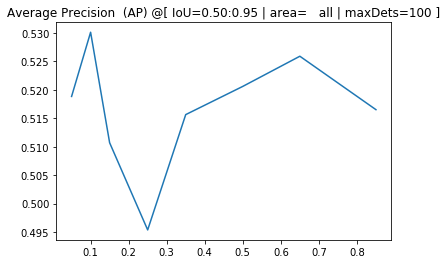

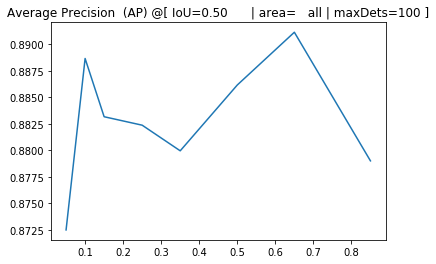

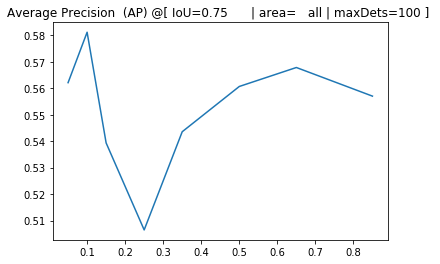

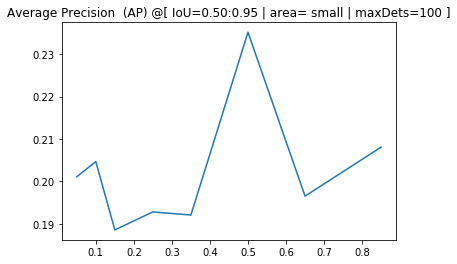

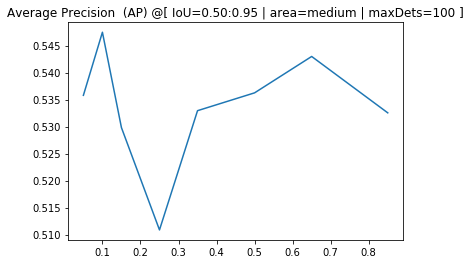

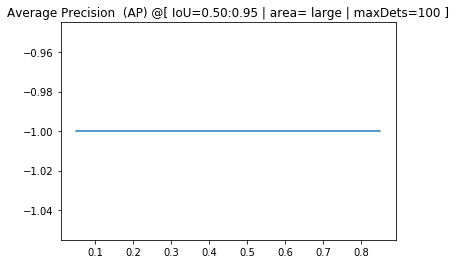

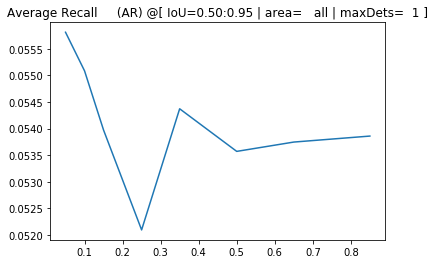

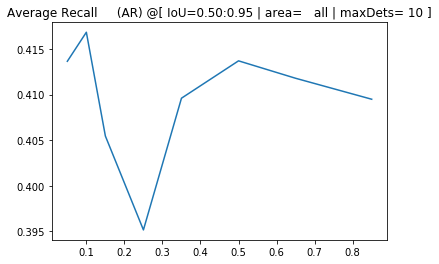

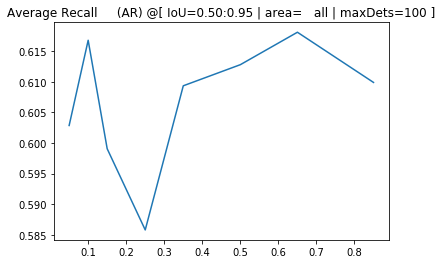

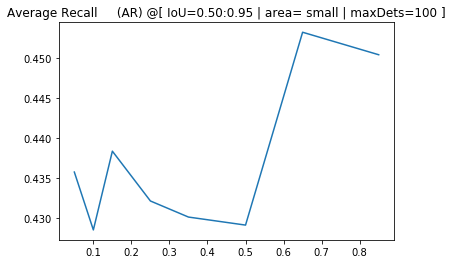

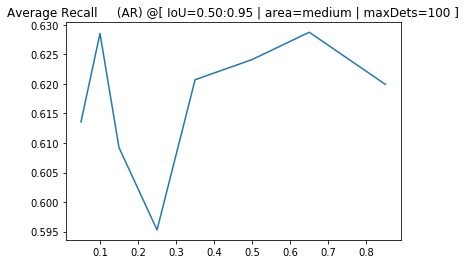

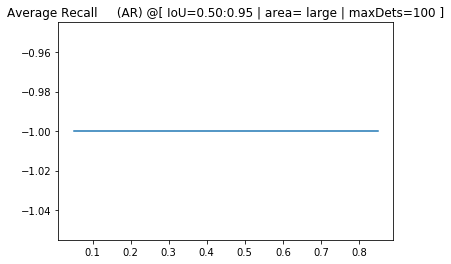

In [65]:
test = [[[0.5198425542276048, 0.5278704965964747, 0.4633324708479973, 0.5182483157367545, 0.5376434164825231, 0.4966778843203582, 0.5531599680513808, 0.5391420880736042], [0.8562373619339082, 0.8896502697318555, 0.8664235738532575, 0.8908596350634291, 0.8886884257186978, 0.877955633784481, 0.9049532213437335, 0.8850272921921093], [0.5649989366792986, 0.5905454005828005, 0.44053153190592376, 0.5619759600056767, 0.5920380692429478, 0.5141071966601444, 0.6255790992512784, 0.6087541252989509], [0.21097326653838833, 0.2064059927126188, 0.13083770141601678, 0.20781789258978864, 0.2029575033880361, 0.23463028830768506, 0.2415018421189171, 0.2124127050161053], [0.5361149497257155, 0.5448285481470772, 0.4873501971717982, 0.5339482003100512, 0.554849378977172, 0.5106239931931478, 0.5694808819011851, 0.5573653980255133], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [0.05613508442776736, 0.053771106941838655, 0.052082551594746715, 0.05418386491557222, 0.054896810506566605, 0.05151969981238275, 0.05602251407129456, 0.05553470919324578], [0.4166604127579737, 0.4142964352720451, 0.3738086303939962, 0.41013133208255165, 0.42063789868667917, 0.40011257035647285, 0.4238273921200751, 0.4238273921200751], [0.6056285178236398, 0.6163977485928706, 0.5631519699812382, 0.6038649155722328, 0.6263789868667917, 0.5977110694183865, 0.6395872420262664, 0.6211632270168855], [0.44337349397590364, 0.4313253012048193, 0.4379518072289157, 0.4512048192771084, 0.45783132530120485, 0.44698795180722894, 0.4542168674698795, 0.45180722891566266], [0.6160956175298804, 0.6282470119521911, 0.571394422310757, 0.6132270916334661, 0.6369721115537849, 0.6071314741035858, 0.6514741035856574, 0.6321513944223108], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]], [[0.5084074737037132, 0.5436593790664546, 0.5481192975408502, 0.44050827037779183, 0.5196415706856591, 0.5215972425017867, 0.4799339854632999, 0.48516648113510585], [0.8850389426350095, 0.8893066231723215, 0.8905338333837595, 0.8706915977263353, 0.868543979036698, 0.8916412766540891, 0.881323856637554, 0.874942949263449], [0.5489210203186907, 0.6011905692106319, 0.6152810910915988, 0.3725714031446741, 0.5550919189511921, 0.5605655566654995, 0.47508094188537636, 0.4914599005241037], [0.1761498568421003, 0.22368610307314926, 0.21699393850899437, 0.15923030415536607, 0.15883533557406565, 0.23506708692543232, 0.18044147377201888, 0.1752308351480517], [0.5260686753103557, 0.5595121617711053, 0.5654575736052386, 0.4546941255320086, 0.537983916678909, 0.5371505728664675, 0.49462824105903413, 0.5004459611820232], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [0.053883677298311436, 0.05662288930581614, 0.05651031894934333, 0.04765478424015009, 0.056735459662288934, 0.05362101313320825, 0.04866791744840525, 0.05328330206378986], [0.4028517823639775, 0.4256660412757974, 0.4275797373358349, 0.3592495309568481, 0.4148217636022514, 0.4137711069418386, 0.38859287054409003, 0.3915572232645404], [0.5930206378986866, 0.6252908067542214, 0.6296060037523452, 0.5360225140712945, 0.6074296435272044, 0.606829268292683, 0.5775609756097562, 0.5862288930581614], [0.4427710843373494, 0.47048192771084346, 0.4716867469879519, 0.41566265060240964, 0.4771084337349397, 0.3933734939759036, 0.44698795180722894, 0.43493975903614457], [0.6026294820717132, 0.634820717131474, 0.6396015936254981, 0.5433864541832668, 0.6157768924302789, 0.6197211155378486, 0.5859760956175298, 0.5958565737051792], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]], [[0.5282225867653483, 0.5187867078253796, 0.520624122764291, 0.5273702956599626, 0.48961720620402926, 0.5434979485592929, 0.5445766469767085, 0.5252047460563286], [0.8762347182265651, 0.8870175851420263, 0.8925517189940325, 0.8855666869832894, 0.8826424279006283, 0.8888822197507174, 0.8871172545220104, 0.8770647595454547], [0.5723310030517744, 0.5516604800196591, 0.5621579674901354, 0.5848415118731682, 0.4835183115213119, 0.6072720045036273, 0.602775108371232, 0.5707815403845307], [0.21615173313327476, 0.18394352231068012, 0.21787178343371041, 0.21138270807511755, 0.21444366285190541, 0.23576116745239514, 0.167632100699533, 0.236594805430749], [0.5451828167393994, 0.5380711559882683, 0.5366188625185879, 0.5439402657410852, 0.505998929367947, 0.5609689220615571, 0.5648423926055013, 0.539819482113542], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [0.05741088180112569, 0.054859287054409, 0.05332082551594747, 0.05444652908067542, 0.05148217636022515, 0.055572232645403376, 0.05654784240150094, 0.052757973733583485], [0.42146341463414644, 0.4105816135084428, 0.4149718574108817, 0.4160600375234521, 0.39335834896810506, 0.42724202626641655, 0.42296435272045035, 0.4130956848030019], [0.6099061913696059, 0.6086679174484052, 0.604390243902439, 0.6174484052532833, 0.5942213883677299, 0.6338461538461538, 0.6371482176360226, 0.6222889305816135], [0.42108433734939765, 0.38373493975903616, 0.4054216867469879, 0.4295180722891566, 0.35542168674698793, 0.44698795180722894, 0.45843373493975903, 0.4644578313253012], [0.6219123505976095, 0.6225099601593626, 0.6166533864541832, 0.6292430278884462, 0.6093625498007968, 0.6454980079681274, 0.6487649402390437, 0.6317529880478088], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]]]
print(annotations_output_path)


## Plot output annotations


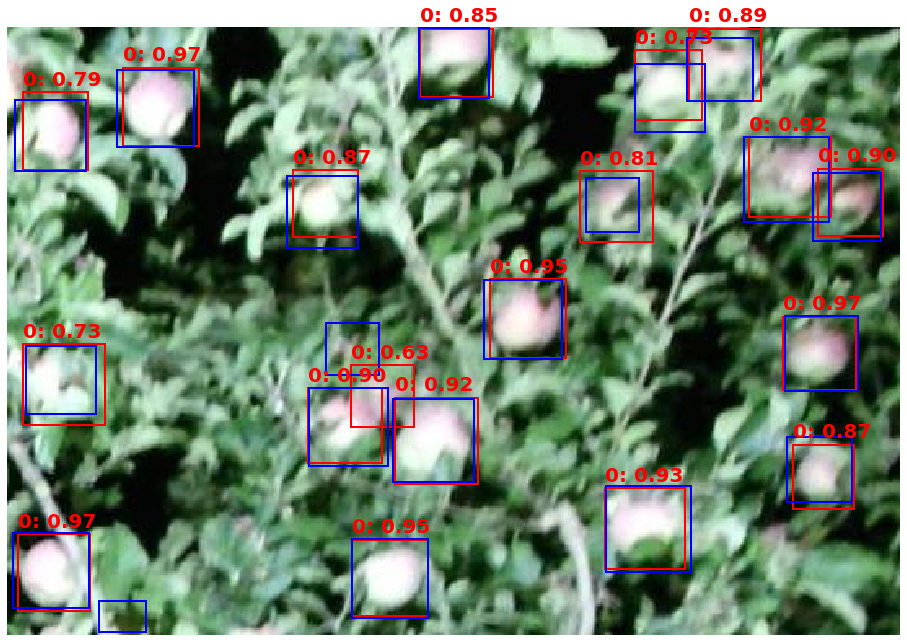

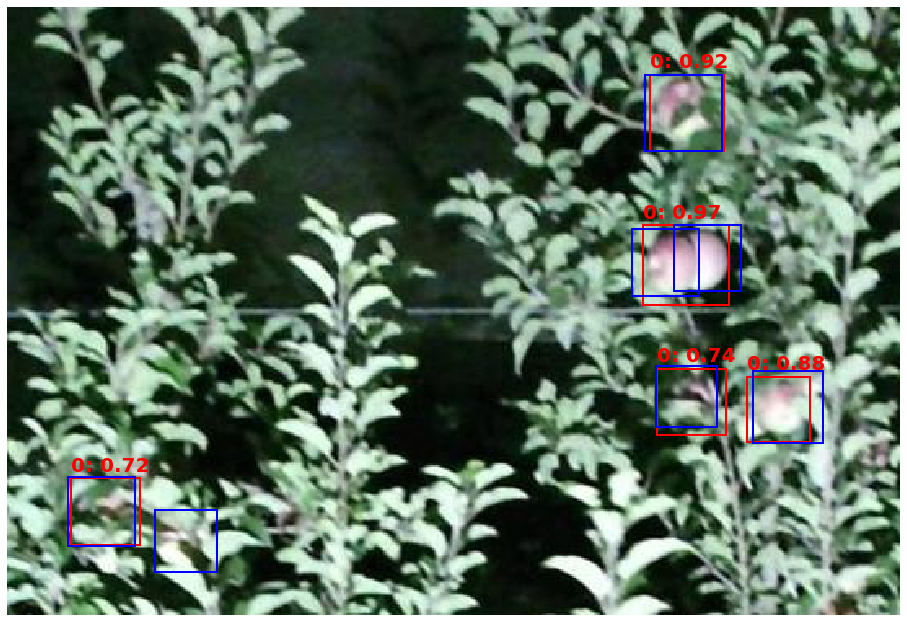

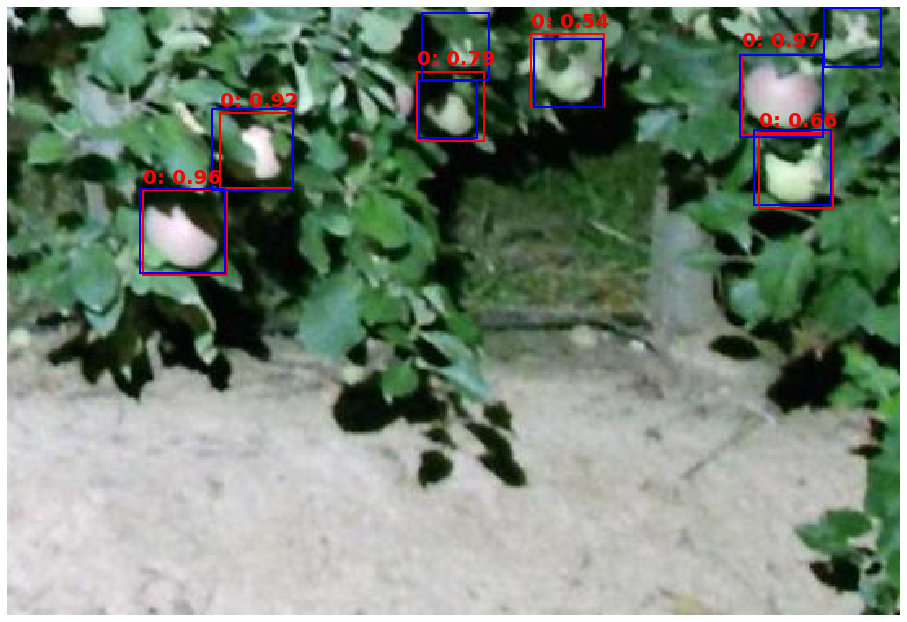

In [51]:
import json
from pathlib import Path
from typing import List

import matplotlib.patches as patches
from matplotlib import pyplot as plt
from skimage import io


def get_bounding_boxes(annotations: List, image_id: int) -> List:
    return [a for a in annotations if a["image_id"] == image_id]


with open(json_output_path, "r") as file:
    all_detections = json.load(file)

with open(test_annotations_path, "r") as file:
    all_ground_truths = json.load(file)

for image_json in all_detections["images"][:3]:
    image_id = image_json["id"]
    image_path = images_path / image_json["file_name"]
    image = io.imread(image_path)

    assert (
        image_json["file_name"]
        == [x["file_name"] for x in all_ground_truths["images"] if x["id"] == image_id][
            0
        ]
    )

    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(image)

    detections = get_bounding_boxes(all_detections["annotations"], image_id)
    detections = [d for d in detections if d["score"] > 0.5]

    ground_truths = get_bounding_boxes(all_ground_truths["annotations"], image_id)

    for d in detections:
        x, y, width, height = d["bbox"]
        score = d["score"]
        category_id = d["category_id"]

        rectangle = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor="r", facecolor="none",
        )
        ax.add_patch(rectangle)

        ax.text(
            x,
            y - 4,
            f"{category_id}: {score:0.2f}",
            color="r",
            fontsize=20,
            fontweight="bold",
        )

    for gt in ground_truths:
        x, y, width, height = gt["bbox"]

        rectangle = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor="b", facecolor="none",
        )
        ax.add_patch(rectangle)

    ax.axis("off")
    plt.show()